# Performance Evaluation

## Helper Functions

In [3]:
### install necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
### defining labels
class_labels = ["unverifiable", "false", "mostly false", "half true", "mostly true", "true"]
class_2_index = {label: i for i, label in enumerate(class_labels)}
index_2_class = {i: label for i, label in enumerate(class_labels)}
num_labels = [class_2_index[label] for label in class_labels] # [0, 1, 2, 3, 4, 5]

In [235]:
### functions to generate confusion matrix and metrics
def generate_cm(y_true, y_pred):
    '''
    Calculate the confusion matrix with the cost matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    return cm

def generate_metrics(y_true, y_pred):
    '''
    Calculate the weighted F1 score
    '''
    weighted_precision = precision_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    weighted_recall = recall_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    metrics = pd.DataFrame({'Precision': weighted_precision, 'Recall': weighted_recall, 'F1': weighted_f1}, index=class_labels)
    return metrics

## Label Generation

In [2]:
### load the data
df = pd.read_csv('../data/[FINAL] Pilot - Pilot Claims copy.csv')
statements = df['statement'].to_list()
statement_dates = df['statement_date'].to_list()
statement_originators = df['statement_originator'].to_list()
gold = df['verdict'].to_list()

'''
Creates a list of strings that contain the statement, source, and date in the following format:
Statement: {statement}
According to: {source}
Date: {date}
'''
statements_agg = [f"""Statement: {statement} \n According to: {source} \n Date: {date}""" for statement, source, date in zip(statements, statement_originators, statement_dates)]

In [38]:
### generate results
def generate_results(statements: list, 
                     old_file: str = None, 
                     new_file: str = None):
    '''
    generate and store results for a list of statements
    make sure to:
    (1) load the old results if they exist
    (2) initialize the pipeline and define LM before running
    (3) run %%capture to suppress output

    '''
    # load results if it exists
    results = []
    if os.path.exists(old_file):
        with open(old_file, 'rb') as f:
            
            results = pickle.load(f)

    for index, statement in enumerate(tqdm(statements)):
        if len(results) <= index+1 and type(results[index]) != int:
            continue
        verdict = None

        # retry 5 times if there is an error
        for i in range(5):
            try:
                verdict, confidence, reasoning, claims = pipeline.fact_check(statement)
            except Exception as e:
                print(f"Error {e}: retrying for statement {index}, attempt {i+1}")
                continue 
            break   
        
        if verdict is None:
            results.append(index)
        else:
            results.append((verdict, confidence, reasoning, claims))
        with open(new_file, 'wb') as f:
            pickle.dump(results, f)

In [39]:
### generate results dataframe
def generate_results_df(results_filename: str,
                        df_filename: str):
    '''
    convert results to a dataframe and save it
    '''
    if os.path.exists(results_filename):
        with open(results_filename, 'rb') as f:
            results = pickle.load(f)
    results_df = pd.DataFrame(data=results, columns=['verdict', 'confidence', 'reasoning', 'claims'])
    results_df.to_csv(df_filename)
    return results_df

### Gemini

In [1]:
%reload_ext autoreload
%autoreload 2

### load fact-checking pipeline
import dotenv
import sys
import dspy
import os
sys.path.append('../pipeline_v2/')
import main 
dotenv.load_dotenv('../.env')

# initialize search provider
main.NUM_SEARCH_RESULTS = 10 # Number of search results to retrieve
main.SCRAPE_TIMEOUT = 5 # Timeout for scraping a webpage (in seconds)
search_provider = main.SearchProvider(provider="duckduckgo")

# initialize DSPy
lm = dspy.LM('gemini/gemini-1.5-flash', api_key=os.getenv('GOOGLE_GEMINI_API_KEY'), cache=False)
#lm = dspy.LM('ollama_chat/mistral', api_base='http://localhost:11434', api_key='')
dspy.settings.configure(lm=lm)

# initialize pipeline
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
main.VERBOSE = True # Print intermediate results
main.INTERACTIVE = False # Allow the user to provide feedback
main.USE_BM25 = True # Use BM25 for retrieval (in addition to cosine similarity)
main.BM25_WEIGHT = 0.5 # Weight for BM25 in the hybrid retrieval

pipeline = main.FactCheckPipeline(
    search_provider=search_provider,
    model_name=lm,
    embedding_model=embedding_model,
    retriever_k=2
)

/opt/homebrew/Caskroom/miniconda/base/envs/ACL/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [299]:
print(main.VERDICTS)

['supported', 'unsupported']


### Mistral

In [35]:
%reload_ext autoreload
%autoreload 2
import dotenv
import sys
import dspy
import os
sys.path.append('../pipeline_v2/')
import main 
dotenv.load_dotenv('../.env')

# Initialize search provider
main.NUM_SEARCH_RESULTS = 10 # Number of search results to retrieve
main.SCRAPE_TIMEOUT = 5 # Timeout for scraping a webpage (in seconds)
search_provider = main.SearchProvider(provider="duckduckgo")

# Initialize DSPy
lm = dspy.LM('ollama_chat/mistral', api_base='http://localhost:11434', api_key='')
dspy.settings.configure(lm=lm)

# Initialize pipeline
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
main.VERBOSE = False # Print intermediate results
main.INTERACTIVE = False # Allow the user to provide feedback
main.USE_BM25 = True # Use BM25 for retrieval (in addition to cosine similarity)
main.BM25_WEIGHT = 0.5 # Weight for BM25 in the hybrid retrieval

pipeline = main.FactCheckPipeline(
    search_provider=search_provider,
    model_name=lm,
    embedding_model=embedding_model,
    retriever_k=2
)


## AVeriTeC

In [24]:
import json

# Open and read the JSON file
with open('data_dev.json', 'r') as file:
    averitec = json.load(file)

averitec_20 = averitec[:20]

In [68]:
averitec_20

[{'claim': 'In a letter to Steve Jobs, Sean Connery refused to appear in an apple commercial.',
  'required_reannotation': False,
  'label': 'Refuted',
  'justification': 'The answer and sources show that the claim was published in a fake news site so the claim is refuted.',
  'claim_date': '31-10-2020',
  'speaker': None,
  'original_claim_url': None,
  'fact_checking_article': 'https://web.archive.org/web/20201130144023/https://checkyourfact.com/2020/11/03/fact-check-sean-connery-letter-steve-jobs-apple-1998/',
  'reporting_source': 'Facebook',
  'location_ISO_code': None,
  'claim_types': ['Event/Property Claim'],
  'fact_checking_strategies': ['Written Evidence'],
  'questions': [{'question': 'Where was the claim first published',
    'answers': [{'answer': 'It was first published on Sccopertino',
      'answer_type': 'Abstractive',
      'source_url': 'https://web.archive.org/web/20201129141238/https://scoopertino.com/exposed-the-imac-disaster-that-almost-was/',
      'source_medi

In [71]:
with open("data_dev_1.json", "w") as final:
	json.dump(averitec_20, final)

In [85]:
averitec_results = []
for s in statements:
    verdict, confidence, reasoning, claims = pipeline.fact_check(s)
    questions = [claim.components[j].question for claim in claims for j in range(len(claim.components))] # List of questions
    answers = [claim.components[j].answer.text for claim in claims for j in range(len(claim.components))] # List of corresponding answers
    urls = ['x' for i in range(len(questions))] # List of corresponding URLs
    pred_label = verdict
    print('='*20)
    print(pred_label)
    averitec_results.append(format_prediction(questions, answers, urls, pred_label))

20

In [84]:
[c['pred_label'] for c in averitec_results]

['Refuted',
 'Refuted',
 'Refuted',
 'Refuted',
 'Refuted',
 'Not Enough Evidence',
 'Supported',
 'Supported',
 'Not Enough Evidence',
 'Supported',
 'Conflicting Evidence/Cherry-picking',
 'Not Enough Evidence',
 'Refuted',
 'Not Enough Evidence',
 'Not Enough Evidence',
 'Not Enough Evidence',
 'Not Enough Evidence',
 'Not Enough Evidence',
 'Not Enough Evidence',
 'Refuted']

In [207]:
df = pd.read_csv('../data/pilot_updated.csv')

In [211]:
df.verdict.value_counts()

verdict
FALSE            40
MOSTLY FALSE     31
MOSTLY TRUE      27
TRUE             25
HALF TRUE        17
PANTS ON FIRE     9
UNVERIFIABLE      1
Name: count, dtype: int64

In [86]:
with open("my_data.json", "w") as final:
	json.dump(averitec_results, final)

# PolitiFact Scraper

In [194]:
import requests
import re
from bs4 import BeautifulSoup
import dateutil.parser as dparser
def scrape_politifact(url):
    """Scrapes text and metadata from a given website URL."""
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            article_element = soup.find('article', class_='m-textblock')
            statement = soup.find('div', class_='m-statement__quote').get_text()
            statement = re.sub(r'\s+', ' ', statement).strip()

            verdict = soup.find('div', class_='m-statement__meter').find('img').get('alt').upper().replace('-',' ')
            if verdict == 'BARELY TRUE':
                verdict = 'MOSTLY FALSE'
            author = soup.find('div',class_="m-statement__author")
            statement_originator = author.find('a',class_='m-statement__name').get_text()
            statement_originator = re.sub(r'\s+', ' ', statement_originator).strip()
            
            statement_date = author.find('div',class_='m-statement__desc').get_text()
            statement_date = re.sub(r'\s+', ' ', statement_date).strip()
            statement_date = dparser.parse(statement_date,fuzzy=True).strftime('%m/%d/%Y')
            if article_element:
                section_element = article_element.find('section', class_='o-pick')
                if section_element:
                    section_element.decompose()
                article_text = article_element.get_text()
                article_text = article_text.replace(u'\xa0', u' ')
                reasoning = re.sub(r'\s+', ' ', article_text).strip()
            return verdict, statement_originator, statement, statement_date, reasoning, url
    except Exception as e:
        print(f"Error during website scraping: {e}")
        return None

In [195]:
urls = ['https://www.politifact.com/factchecks/2025/jan/30/karoline-leavitt/no-the-us-did-not-spend-50-million-to-fund-condoms/',
        'https://www.politifact.com/factchecks/2025/jan/30/elizabeth-warren/whats-the-evidence-rfk-jr-profited-off-vaccine-law/',
        'https://www.politifact.com/factchecks/2024/nov/04/winsenate/democratic-ad-misleads-on-kari-lakes-support-for-s/',
        ]

In [196]:
factcheck_urls = [
    "https://www.politifact.com/factchecks/list/?ruling=half-true",
    "https://www.politifact.com/factchecks/list/?ruling=true",
    "https://www.politifact.com/factchecks/list/?ruling=false",
    "https://www.politifact.com/factchecks/list/?ruling=mostly-true",
    "https://www.politifact.com/factchecks/list/?ruling=barely-true",
    "https://www.politifact.com/factchecks/list/?ruling=pants-fire",
]


In [204]:
new_data = pd.DataFrame(data, columns=['verdict', 'statement_originator', 'statement', 'statement_date', 'reasoning', 'url'])

In [203]:
data = []
for ruling in factcheck_urls:
    response = requests.get(ruling, timeout=5)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        article_element = soup.find_all('li', class_='o-listicle__item')
        print(len(article_element))
    for i in range(30):
        ref = article_element[i].find('div', class_='m-statement__quote').find('a').get('href')
        url = f'https://www.politifact.com{ref}'
        print(url)
        news = scrape_politifact(url)
        data.append(news)

30
https://www.politifact.com/factchecks/2025/jan/30/karoline-leavitt/karoline-leavitt-blames-biden-for-egg-shortage-but/
https://www.politifact.com/factchecks/2025/jan/30/elizabeth-warren/whats-the-evidence-rfk-jr-profited-off-vaccine-law/
https://www.politifact.com/factchecks/2025/jan/29/roy-cooper/roy-cooper-says-hurricane-helene-relief-bill-took/
https://www.politifact.com/factchecks/2025/jan/17/dana-loesch/are-north-carolinas-helene-victims-still-required/
https://www.politifact.com/factchecks/2025/jan/06/social-media/poll-shows-trump-won-18-24-year-olds-in-wisconsin/
https://www.politifact.com/factchecks/2024/dec/10/tweets/how-much-temporary-housing-has-fema-provided-to-nc/
https://www.politifact.com/factchecks/2024/nov/04/winsenate/democratic-ad-misleads-on-kari-lakes-support-for-s/
https://www.politifact.com/factchecks/2024/nov/01/make-the-road-nevada/nevada-political-action-committee-gets-some-right/
https://www.politifact.com/factchecks/2024/oct/30/viral-image/an-abc-news-aff

# LLM-AggreFact 

In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import balanced_accuracy_score
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Pipeline

In [16]:
from termcolor import colored
from utils import print_header

def print_final_result(statement, verdict, confidence, reasoning, gold_verdict=None):
    print("\nFinal Fact-Check Result:")
    print_header(f"Statement: {colored(statement, 'white')}", level=1)
    print_header(f"Overall Verdict: {colored(verdict, 'green')}", level=1)
    print_header(f"Overall Confidence: {colored(str(confidence), 'yellow')}", level=1)
    print_header(f"Overall Reasoning: {colored(reasoning, 'cyan')}", level=1)
    if gold_verdict: print_header(f"Gold Verdict: {colored(gold_verdict, 'green')}", level=1)

### Load data
# output_file = args.output_file
# if os.path.exists(output_file):
#     df = pd.read_pickle(output_file)
# Set custom constants for whole pipeline
# main.VERBOSE = False # Print intermediate results
main.VERDICTS=["unsupported", "supported"]

model = 'gemini'
num_trials = 3
lm = dspy.LM('gemini/gemini-1.5-flash', api_key=os.getenv('GOOGLE_GEMINI_API_KEY'), cache=False)
output_file = f'aggrefact_{model}.pkl'
if os.path.exists(output_file):
    df = pd.read_pickle(output_file)
else: 
    df = pd.DataFrame(load_dataset("lytang/LLM-AggreFact")['test'])
    # Drop unneeded columns
    df = df[df['dataset'].isin(['RAGTruth','ExpertQA','Lfqa','ClaimVerify'])]
    df = df.groupby('dataset').apply(lambda x: x.sample(frac=0.01, random_state=42))
    df.reset_index(drop=True, inplace=True)
dspy.settings.configure(lm=lm, temperature=0.3)

# If column doesn't exist, create it
if f'{model}_results' not in df.columns: df[f'{model}_results'] = None
df[f'{model}_results'] = df[f'{model}_results'].astype(object)
display(df.head())

for index in tqdm(range(len(df))):
    # If results already exist, skip if num_trials is reached
    if df.iloc[index][f'{model}_results'] is not None: 
        if len(df.loc[index, f'{model}_results']) == num_trials:
            print(f"Skipping row {index} because {num_trials}/{num_trials} trials completed")
            continue
        else:
            print(f"Running row {index} because {len(df.loc[index, f'{model}_results'])}/{num_trials} trials completed")
            results = df.loc[index, f'{model}_results']
    else: 
        print(f"Running row {index} because 0/{num_trials} trials completed")
        results = []

    for trial_i in tqdm(range(num_trials-len(results)), leave=False):
        source_doc = df.iloc[index]['doc']
        pipeline = main.FactCheckPipeline(
            search_provider=main.SearchProvider(provider="duckduckgo"),
            model_name=lm,
            embedding_model=main.EMBEDDING_MODEL,
            context=[main.Document(content=source_doc, metadata={"source": "source"})],
            retriever_k=5
        )

        statement = df.iloc[index]['claim']
        gold_verdict = df.iloc[index]['label']
        try: 
            verdict, confidence, reasoning, claims = pipeline.fact_check(
                # statement=f"According to {statement_originator} on {statement_date}, {statement}", 
                statement=statement, 
                web_search=False
                # statement=statement, 
                # context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
            )
        except Exception as e: 
            if 'Failed to extract claim' in str(e): 
                continue

        print_final_result(statement, verdict, confidence, reasoning, gold_verdict)
        results.append({
            'verdict': verdict,
            'confidence': confidence,
            'reasoning': reasoning,
            'claims': claims
        })
        df.at[index, f'{model}_results'] = results
        df.to_pickle(output_file)

,dataset,doc,claim,label,contamination_identifier,gemini_results
0,ClaimVerify,Using acrylic paint is a fun and economical wa...,You can use a single acrylic paint color or mi...,1,LLM-AggreFact:PuKGySjD1LKX354etBOla3Ke9VjVBmYR...,"[{'verdict': 'supported', 'confidence': 1.0, '..."
1,ClaimVerify,"Recipe by rjholtz\nUpdated on April 23, 2023\n...",You can also grill tilapia in foil or use othe...,1,LLM-AggreFact:nGjDY4zLhqIU5KzXn5YqfKdQDL72ru6u...,"[{'verdict': 'supported', 'confidence': 0.95, ..."
2,ClaimVerify,Listen to Chuck Swindoll’s overview of First J...,The author of the book of First John is not id...,1,LLM-AggreFact:3EjFNtDyEESiwE3PKH4eILjTpzVzoQRv...,"[{'verdict': 'supported', 'confidence': 0.9, '..."
3,ClaimVerify,Agender is defined as not having a gender. Som...,Agender people may use gender-neutral pronouns...,0,LLM-AggreFact:kgftCc3SYJipb7CnIJHAuTjCgljJ4LhQ...,"[{'verdict': 'unsupported', 'confidence': 0.6,..."
4,ClaimVerify,"2000, Comedy/Drama, 1h 46m\nCritics Consensus\...","The cast of O Brother, Where Art Thou? include...",0,LLM-AggreFact:31kK2h5aC3tGW4bFrV3z5yXj7vznzrlV...,"[{'verdict': 'partially supported', 'confidenc..."


  0%|          | 0/231 [00:00<?, ?it/s]

Skipping row 0 because 3/3 trials completed
Skipping row 1 because 3/3 trials completed
Skipping row 2 because 3/3 trials completed
Skipping row 3 because 3/3 trials completed
Skipping row 4 because 3/3 trials completed
Skipping row 5 because 3/3 trials completed
Skipping row 6 because 3/3 trials completed
Skipping row 7 because 3/3 trials completed
Skipping row 8 because 3/3 trials completed
Skipping row 9 because 3/3 trials completed
Skipping row 10 because 3/3 trials completed
Skipping row 11 because 3/3 trials completed
Skipping row 12 because 3/3 trials completed
Skipping row 13 because 3/3 trials completed
Skipping row 14 because 3/3 trials completed
Skipping row 15 because 3/3 trials completed
Skipping row 16 because 3/3 trials completed
Skipping row 17 because 3/3 trials completed
Skipping row 18 because 3/3 trials completed
Skipping row 19 because 3/3 trials completed
Skipping row 20 because 3/3 trials completed
Skipping row 21 because 3/3 trials completed
Skipping row 22 beca

  0%|          | 0/2 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Passage 3 provides information on the varying pay structures among different companies, with some offering hourly and commission pay rates, while others may use a combination of both. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. Passage 3 indicates that different companies utilize varying pay structures, including hourly rates, commission-based rates, or a combination of both. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: What types of pay structures are mentioned in Passage 3 as being used by different companies? 
            Search Queries: ['Passage 3 pay structures companies'] 
      ===== Question Answering for Component [1/1] =====
         Question: What types of pay structures are mentioned in Passage 3 as being used by different companies? 
         Search Queries: ['Passage 3 pay structures companies'] 
 

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: It is a mutable sign that indicates the end of spring and the coming change of seasons. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. It is a mutable sign that indicates the end of spring and the coming change of seasons. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (3): 
         1. Question: What is 'it' referring to in the statement? 
            Search Queries: ["contextual meaning of 'it' in relation to mutable sign, spring, and seasonal change"] 
         2. Question: What are the characteristics of a 'mutable sign' in the context of astrology or seasonal changes? 
            Search Queries: ['definition mutable sign astrology', 'mutable signs and seasonal transitions'] 
         3. Question: How does the identified 'it' signify the end of spring and the beginning of a new season? 
            Search Queries: ["[identified 'it'] and en

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: They also mentioned the quaint but small eating area and the adorable cupcakes. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. The eating area is quaint but small. 
     2. The cupcakes are adorable. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: What is the size and atmosphere of the eating area? 
            Search Queries: ['reviews of [restaurant name] eating area size and ambiance', '[restaurant name] customer reviews dining area description'] 
      ===== Question Answering for Component [1/1] =====
         Question: What is the size and atmosphere of the eating area? 
         Search Queries: ['reviews of [restaurant name] eating area size and ambiance', '[restaurant name] customer reviews dining area description'] 
        ===== Web Search for Query [1/2] =====
         Query: reviews of [restaurant name] eat

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: However, some customers have noted that the prices are high and one reviewer had a negative experience with customer service. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. Some customers have noted that the prices are high. 
     2. One reviewer had a negative experience with customer service. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: How many customers have complained about high prices for this product/service? 
            Search Queries: ['customer reviews [product/service name] high prices', '[product/service name] price complaints'] 
      ===== Question Answering for Component [1/1] =====
         Question: How many customers have complained about high prices for this product/service? 
         Search Queries: ['customer reviews [product/service name] high prices', '[product/service name] price complaints'

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: The wire was allegedly being cut to allow migrants to cross into Texas. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. A wire was allegedly being cut to allow migrants to cross into Texas. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: Were there any reported incidents of wire being cut along the Texas border during the period in question? 
            Search Queries: ['Texas border wire cutting incidents', 'reports of border fence damage Texas'] 
         2. Question: Is there evidence linking these wire-cutting incidents to the facilitation of illegal migrant crossings into Texas? 
            Search Queries: ['correlation wire cutting migrant crossings Texas', 'evidence linking border fence damage to illegal immigration Texas'] 
      ===== Question Answering for Component [1/2] =====
         Question: Were there 

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: The blue field should be burned in a peaceful manner and the ashes buried. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. The blue field should be burned in a peaceful manner and the ashes buried. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: What is meant by 'blue field' in this context? 
            Search Queries: ['definition blue field', 'blue field symbolism', 'blue field agriculture', 'blue field art'] 
         2. Question: What is the rationale or purpose behind burning the blue field and burying the ashes? 
            Search Queries: ['ritualistic burning of fields', 'symbolic burial of ashes', 'environmental reasons for burning fields'] 
      ===== Question Answering for Component [1/2] =====
         Question: What is meant by 'blue field' in this context? 
         Search Queries: ['definition blue fie

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: On the other hand, the sirloin steak is a steak cut from the back of the animal, continuing off the short loin from which T-bone, porterhouse, and club steaks are cut. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. The sirloin steak is a steak cut from the back of the animal, continuing off the short loin from which T-bone, porterhouse, and club steaks are cut. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: What is the anatomical location of a sirloin steak on a cow? 
            Search Queries: ['sirloin steak location cow anatomy diagram'] 
         2. Question: Which other steak cuts are derived from the short loin of a cow? 
            Search Queries: ['short loin steak cuts', 'T-bone porterhouse club steak origin'] 
      ===== Question Answering for Component [1/2] =====
         Question: What is the anatomica

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: It has a rating of 3.0 stars based on customer reviews and offers a variety of traditional Chinese dishes, including Mongolian cuisine. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. The restaurant has a rating of 3.0 stars based on customer reviews. 
     2. The restaurant offers a variety of traditional Chinese dishes, including Mongolian cuisine. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: What is the average star rating of the restaurant based on customer reviews? 
            Search Queries: ['restaurant name customer reviews rating', '[restaurant name] reviews stars'] 
      ===== Question Answering for Component [1/1] =====
         Question: What is the average star rating of the restaurant based on customer reviews? 
         Search Queries: ['restaurant name customer reviews rating', '[restaurant name] re

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Finally, dab this with a paper towel or cloth to remove excess paint. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. To remove excess paint, dab the painted surface with a paper towel or cloth. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: How effective are paper towels and cloths at absorbing excess paint of various types (e.g., water-based, oil-based)? 
            Search Queries: ['effectiveness of paper towels absorbing paint', 'absorbency of cloth vs paper towel for paint cleanup'] 
      ===== Question Answering for Component [1/1] =====
         Question: How effective are paper towels and cloths at absorbing excess paint of various types (e.g., water-based, oil-based)? 
         Search Queries: ['effectiveness of paper towels absorbing paint', 'absorbency of cloth vs paper towel for paint cleanup'] 
        =

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Overall, American Ale is a pub and restaurant in Santa Barbara that offers American cuisine and has received a rating of 4.0 stars from customers. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. American Ale is a pub and restaurant in Santa Barbara that offers American cuisine and has received a rating of 4.0 stars from customers. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: Is American Ale a pub and restaurant located in Santa Barbara, California, that serves American cuisine? 
            Search Queries: ['American Ale Santa Barbara menu', 'American Ale Santa Barbara reviews'] 
         2. Question: What is the average customer rating for American Ale on review platforms like Yelp, Google Reviews, or TripAdvisor? 
            Search Queries: ['American Ale Santa Barbara Yelp rating', 'American Ale Santa Barbara Goo

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: The business has a validated parking lot and offers outdoor seating, Wi-Fi, and takeout options. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (3):  
     1. The business has a validated parking lot. 
     2. The business offers outdoor seating. 
     3. The business offers Wi-Fi and takeout options. 
    ===== Question Generation [1/3] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: Does the business offer validated parking? 
            Search Queries: ['business name parking validation', 'business address parking validation'] 
      ===== Question Answering for Component [1/1] =====
         Question: Does the business offer validated parking? 
         Search Queries: ['business name parking validation', 'business address parking validation'] 
        ===== Web Search for Query [1/2] =====
         Query: business name parking validation 
        ===== Web Search f

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Crushcakes & Co is a popular bakery and cafe located in Montecito, California, serving up delicious desserts and drinks. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. Crushcakes & Co is a popular bakery and cafe located in Montecito, California, serving delicious desserts and drinks. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: Does a bakery and cafe called Crushcakes & Co exist in Montecito, California? 
            Search Queries: ['Crushcakes & Co Montecito CA', 'Crushcakes & Co bakery Montecito'] 
         2. Question: What type of desserts and drinks does Crushcakes & Co offer? 
            Search Queries: ['Crushcakes & Co menu', 'Crushcakes & Co desserts'] 
      ===== Question Answering for Component [1/2] =====
         Question: Does a bakery and cafe called Crushcakes & Co exist in Montecito, California?

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: The show airs weekdays on CBS and streams on Paramount Plus. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. The show airs weekdays on CBS. 
     2. The show streams on Paramount Plus. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: On which television channel does the show air? 
            Search Queries: ['[Show Name] TV channel'] 
         2. Question: What are the days of the week the show airs on CBS? 
            Search Queries: ['[Show Name] air times CBS', '[Show Name] schedule CBS'] 
      ===== Question Answering for Component [1/2] =====
         Question: On which television channel does the show air? 
         Search Queries: ['[Show Name] TV channel'] 
        ===== Web Search for Query [1/1] =====
         Query: [Show Name] TV channel 
      ===== Synthesizing Answer [1/2] =====
         Question: On wh

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Customers can place reservations, take out their orders, and enjoy the ambience of the casual establishment. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (3):  
     1. Customers can place reservations at the casual establishment. 
     2. Customers can take out their orders from the casual establishment. 
     3. The casual establishment offers a pleasant ambience for customers to enjoy. 
    ===== Question Generation [1/3] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: Does this casual establishment accept reservations? 
            Search Queries: ['[Establishment Name] reservation policy'] 
      ===== Question Answering for Component [1/1] =====
         Question: Does this casual establishment accept reservations? 
         Search Queries: ['[Establishment Name] reservation policy'] 
        ===== Web Search for Query [1/1] =====
         Query: [Establishment 

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: He noticed his own injuries, including his Achilles tendon and left tibia. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. The speaker noticed injuries to his Achilles tendon and left tibia. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: Did the speaker sustain an injury to his Achilles tendon? 
            Search Queries: ['Achilles tendon injury medical definition', 'symptoms of Achilles tendon rupture'] 
         2. Question: Did the speaker sustain an injury to his left tibia? 
            Search Queries: ['left tibia fracture symptoms', 'left tibia injury diagnosis'] 
      ===== Question Answering for Component [1/2] =====
         Question: Did the speaker sustain an injury to his Achilles tendon? 
         Search Queries: ['Achilles tendon injury medical definition', 'symptoms of Achilles tendon rupture'] 
    

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: According to the review, the customer met Katie at the bar and they hit it off immediately, thanks to the help of the friendly bartenders. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. According to a review, a customer met Katie at a bar and they connected immediately due to the friendly bartenders. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (3): 
         1. Question: Where did the customer meet Katie, according to the review? 
            Search Queries: ['review location Katie meeting'] 
         2. Question: Did the customer and Katie connect immediately upon meeting, according to the review? 
            Search Queries: ['review immediate connection Katie customer'] 
         3. Question: Did the review mention friendly bartenders contributing to the customer and Katie connecting? 
            Search Queries: ['review friendly bartende

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: The restaurant offers a unique blend of modern and traditional Chinese cuisine, using fresh and high-quality ingredients. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. The restaurant offers a unique blend of modern and traditional Chinese cuisine. 
     2. The restaurant uses fresh and high-quality ingredients. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (3): 
         1. Question: What specific dishes on the restaurant's menu represent modern interpretations of Chinese cuisine? 
            Search Queries: ['[Restaurant Name] menu modern Chinese dishes', '[Restaurant Name] innovative Chinese dishes'] 
         2. Question: What specific dishes on the restaurant's menu represent traditional Chinese cuisine? 
            Search Queries: ['[Restaurant Name] menu traditional Chinese dishes', '[Restaurant Name] classic Chinese dishes'] 
        

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Winchell's Donuts is a popular donut shop located in Santa Barbara, CA. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. Winchell's Donuts is a popular donut shop located in Santa Barbara, CA. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: Is there a Winchell's Donuts location in Santa Barbara, CA? 
            Search Queries: ["Winchell's Donuts Santa Barbara CA location", "Winchell's Donuts Santa Barbara address"] 
         2. Question: What is the online reputation and customer feedback for Winchell's Donuts in Santa Barbara, CA? 
            Search Queries: ["Winchell's Donuts Santa Barbara reviews", "Winchell's Donuts Santa Barbara Yelp"] 
      ===== Question Answering for Component [1/2] =====
         Question: Is there a Winchell's Donuts location in Santa Barbara, CA? 
         Search Queries: ["Winchell's Don

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: In a bowl, mix together seasoned salt, black pepper, garlic powder, onion powder, paprika, Worcestershire sauce, and smoke flavoring until thoroughly combined. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. Mixing seasoned salt, black pepper, garlic powder, onion powder, paprika, Worcestershire sauce, and smoke flavoring in a bowl until thoroughly combined will produce a seasoned blend. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: What are the common components of commercially available dry seasoning blends? 
            Search Queries: ['common dry seasoning blend ingredients', 'types of spice blends'] 
         2. Question: Does combining seasoned salt, black pepper, garlic powder, onion powder, paprika, Worcestershire sauce, and smoke flavoring create a flavor profile commonly associated with seasoning? 
        

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Wisconsin rallied for a tough 71-64 victory, led by Frank Kaminsky who scored 20 points and 11 rebounds. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (3):  
     1. Wisconsin won a basketball game against an unspecified opponent with a score of 71-64. 
     2. Frank Kaminsky scored 20 points in the Wisconsin basketball game. 
     3. Frank Kaminsky had 11 rebounds in the Wisconsin basketball game. 
    ===== Question Generation [1/3] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: Did Wisconsin win a basketball game with a final score of 71-64? 
            Search Queries: ['Wisconsin basketball game results 71-64'] 
      ===== Question Answering for Component [1/1] =====
         Question: Did Wisconsin win a basketball game with a final score of 71-64? 
         Search Queries: ['Wisconsin basketball game results 71-64'] 
        ===== Web Search for Query [1/1] ==

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: Cover the grill and cook for 5 minutes. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. Cover the grill and cook for 5 minutes. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (0): 
    ===== Claim Evaluation =====
       Claim: Cover the grill and cook for 5 minutes. 
       Verdict: unsupported 
       Confidence: 0.0 
       Reasoning: There are no question-answer pairs provided to evaluate the claim "Cover the grill and cook for 5 minutes".  Therefore, it's impossible to determine if the claim is supported or unsupported by evidence. 
       Evidence Analysis 
===== Breakdown of Claims and Components =====
   Claim 1 
     Text: Cover the grill and cook for 5 minutes. 
     Verdict: unsupported 
     Confidence: 0.0 
     Reasoning: There are no question-answer pairs provided to evaluate the claim "Cover the grill and cook for 5 minutes".  The

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: They lauded the customer service and the ability to customize their order. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. Customers lauded the customer service. 
     2. Customers lauded the ability to customize their order. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (1): 
         1. Question: What specific aspects of customer service did customers praise in reviews or feedback for this company/product? 
            Search Queries: ['customer reviews [company name/product name] customer service', '[company name/product name] customer service feedback analysis'] 
      ===== Question Answering for Component [1/1] =====
         Question: What specific aspects of customer service did customers praise in reviews or feedback for this company/product? 
         Search Queries: ['customer reviews [company name/product name] customer service', '[c

  0%|          | 0/3 [00:00<?, ?it/s]

===== Starting Fact Check Pipeline =====
 Original Statement: The cause remains unknown and the ship has increased cleaning and disinfection procedures. 
  ===== Atomic Claim Extraction =====
   Extracted Claims (2):  
     1. The cause remains unknown. 
     2. The ship has increased cleaning and disinfection procedures. 
    ===== Question Generation [1/2] =====
       Decomposed Components (Questions + Search Queries) (2): 
         1. Question: What investigations have been conducted to determine the cause of the issue? 
            Search Queries: ['investigation report', 'cause of incident report'] 
         2. Question: What specific challenges or limitations hindered the identification of the cause? 
            Search Queries: ['investigation limitations', 'unidentified cause explanation'] 
      ===== Question Answering for Component [1/2] =====
         Question: What investigations have been conducted to determine the cause of the issue? 
         Search Queries: ['investig

### Baseline

In [79]:
# Initialize baseline
VERDICTS = ['supported','unsupported']
class StatementFactCheckerSignature(dspy.Signature):
    f"""Fact check the given statement and context into one of the following verdicts: {", ".join(VERDICTS)}"""
    statement = dspy.InputField(desc="Statement to evaluate")
    verdict = dspy.OutputField(desc=f"Truthful classification of the statement into one of the following verdicts: {', '.join(main.VERDICTS)}")

class StatementFactChecker(dspy.Module):
    def __init__(self):
        super().__init__()
        self.fact_check = dspy.ChainOfThought(StatementFactCheckerSignature)

    def forward(self, statement: str):
        result = self.fact_check(statement=statement)
        verdict = result["verdict"]
        reasoning = result["reasoning"]
        return verdict, reasoning
    
baseline = StatementFactChecker()

if os.path.exists(output_file):
    df_1 = pd.read_pickle(output_file)

# If baseline results column doesn't exist, create it
if f'{model}_baseline_results' not in df_1.columns: df_1[f'{model}_baseline_results'] = None
df_1[f'{model}_baseline_results'] = df_1[f'{model}_baseline_results'].astype(object)

for index in tqdm(range(len(df_1))):
    # If results already exist, skip if num_trials is reached
    if df_1.loc[index, f'{model}_baseline_results'] is not None: 
        if len(df_1.loc[index, f'{model}_baseline_results']) == num_trials:
            print(f"Skipping row {index} because {num_trials}/{num_trials} trials completed")
            continue
        else:
            print(f"Running row {index} because {len(df_1.loc[index, f'{model}_baseline_results'])}/{num_trials} trials completed")
            results = df_1.loc[index, f'{model}_baseline_results']
    else: 
        print(f"Running row {index} because 0/{num_trials} trials completed")
        results = []

    for trial_i in tqdm(range(num_trials-len(results)), leave=False):
        statement = df_1.iloc[index]['claim']
        gold_verdict = df_1.iloc[index]['label']

        verdict, reasoning = baseline(f"{statement}")
        print_final_result(statement, verdict, 'N/A', reasoning, gold_verdict)

        results.append({
            'verdict': verdict,
            'reasoning': reasoning
        })

        df_1.at[index, f'{model}_baseline_results'] = results
        df_1.to_pickle(output_file)

  0%|          | 0/231 [00:00<?, ?it/s]

Skipping row 0 because 3/3 trials completed
Skipping row 1 because 3/3 trials completed
Skipping row 2 because 3/3 trials completed
Skipping row 3 because 3/3 trials completed
Skipping row 4 because 3/3 trials completed
Skipping row 5 because 3/3 trials completed
Skipping row 6 because 3/3 trials completed
Skipping row 7 because 3/3 trials completed
Skipping row 8 because 3/3 trials completed
Skipping row 9 because 3/3 trials completed
Skipping row 10 because 3/3 trials completed
Skipping row 11 because 3/3 trials completed
Skipping row 12 because 3/3 trials completed
Skipping row 13 because 3/3 trials completed
Skipping row 14 because 3/3 trials completed
Skipping row 15 because 3/3 trials completed
Skipping row 16 because 3/3 trials completed
Skipping row 17 because 3/3 trials completed
Skipping row 18 because 3/3 trials completed
Skipping row 19 because 3/3 trials completed
Skipping row 20 because 3/3 trials completed
Skipping row 21 because 3/3 trials completed
Skipping row 22 beca

  0%|          | 0/2 [00:00<?, ?it/s]


Final Fact-Check Result:
   Statement: In a bowl, mix together seasoned salt, black pepper, garlic powder, onion powder, paprika, Worcestershire sauce, and smoke flavoring until thoroughly combined. 
   Overall Verdict: supported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement describes a straightforward process of combining several ingredients in a bowl.  There's no inherent falsehood or unsupported claim within the instructions.  The process is entirely feasible and commonly done in cooking. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: In a bowl, mix together seasoned salt, black pepper, garlic powder, onion powder, paprika, Worcestershire sauce, and smoke flavoring until thoroughly combined. 
   Overall Verdict: supported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement describes a straightforward process of combining several ingredients in a bowl.  There's no inherent falsehood or unsupported claim within the instructions.  The proc

  0%|          | 0/3 [00:00<?, ?it/s]


Final Fact-Check Result:
   Statement: Wisconsin rallied for a tough 71-64 victory, led by Frank Kaminsky who scored 20 points and 11 rebounds. 
   Overall Verdict: supported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement describes a basketball game where Wisconsin won 71-64, with Frank Kaminsky contributing 20 points and 11 rebounds.  This is a factual claim that can be verified through box scores and game reports from the specific game in question.  Without access to those sources, I cannot definitively confirm the accuracy of the statement. However, the statement is presented as a factual account of a sporting event, and such accounts are commonly reported and verifiable. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: Wisconsin rallied for a tough 71-64 victory, led by Frank Kaminsky who scored 20 points and 11 rebounds. 
   Overall Verdict: supported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement describes a basketball game where W

  0%|          | 0/3 [00:00<?, ?it/s]


Final Fact-Check Result:
   Statement: Cover the grill and cook for 5 minutes. 
   Overall Verdict: unsupported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement "Cover the grill and cook for 5 minutes" is a directive or instruction, not a factual statement that can be evaluated as true or false.  Therefore, it cannot be classified as supported or unsupported. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: Cover the grill and cook for 5 minutes. 
   Overall Verdict: unsupported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement "Cover the grill and cook for 5 minutes" is a directive or instruction, not a factual statement that can be evaluated as true or false.  Therefore, it cannot be classified as supported or unsupported. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: Cover the grill and cook for 5 minutes. 
   Overall Verdict: unsupported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement "Cover the grill and c

  0%|          | 0/3 [00:00<?, ?it/s]


Final Fact-Check Result:
   Statement: They lauded the customer service and the ability to customize their order. 
   Overall Verdict: supported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement presents a positive assessment of a service, highlighting aspects like customer service and customization options.  Without further context or evidence to contradict this, the statement can be considered supported. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: They lauded the customer service and the ability to customize their order. 
   Overall Verdict: supported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement presents a positive assessment of a service, highlighting aspects like customer service and customization options.  Without further context or evidence to the contrary, the statement can be considered supported. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: They lauded the customer service and the ability to customize their o

  0%|          | 0/3 [00:00<?, ?it/s]


Final Fact-Check Result:
   Statement: The cause remains unknown and the ship has increased cleaning and disinfection procedures. 
   Overall Verdict: unsupported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement presents two separate pieces of information: the cause of something is unknown, and a ship has increased its cleaning and disinfection procedures.  While these are related in that increased cleaning might be a response to an unknown cause, the statement itself doesn't offer evidence to support or refute either claim independently.  We cannot verify the existence of an unknown cause, nor can we independently verify the increased cleaning procedures. 
   Gold Verdict: 1 

Final Fact-Check Result:
   Statement: The cause remains unknown and the ship has increased cleaning and disinfection procedures. 
   Overall Verdict: unsupported 
   Overall Confidence: N/A 
   Overall Reasoning: The statement presents two separate pieces of information: the cause of something 

In [84]:
output_file = 'results_v2_gemini.pkl'
if os.path.exists(output_file):
    df = pd.read_pickle(output_file)

In [105]:
df['gemini_results'][0][0]['claims'][0].components[2].answer.citations[0].source_url

'https://content.govdelivery.com/accounts/WIGOV/bulletins/3c856e9'

# Multiclass classification

In [1]:
import pandas as pd
import sys
sys.path.append('../pipeline_v2/')
import main 
import numpy as np
import pickle

df_gemini = pd.read_pickle('results_v2_gemini.pkl')
df_mistral = pd.read_pickle('results_v2_mistral.pkl')
with open('results_v2_mistral.pkl', 'rb') as file:
    data = pickle.load(file)
    df_mistral = pd.DataFrame(data)

/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [12]:
# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "PANTS ON FIRE": 1, # Pants on fire is the same as false
    "MOSTLY UNVERIFIABLE": 0,
    "INDIFFERENT": 0,
    'MOSTLY HALF TRUE': 4,
    'PARTIALLY TRUE': 3,
}

def get_results(df):
    # Convert verdicts to numeric values
    true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]
    pass1_preds_baseline = [VERDICT_MAP[v] for v in df['baseline_pass1_verdict']]
    pass1_preds_pipeline = [VERDICT_MAP[v] for v in df['pipeline_pass1_verdict']]
    pass3_preds_baseline = [VERDICT_MAP[v] for v in df['baseline_pass3_verdict']]
    pass3_preds_pipeline = [VERDICT_MAP[v] for v in df['pipeline_pass3_verdict']]

    cohen_base_1_idx = [i for i, e in enumerate(pass1_preds_baseline) if e == 0]
    cohen_base_1_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_base_1_idx]
    cohen_base_1_pred = [e for i, e in enumerate(pass1_preds_baseline) if i not in cohen_base_1_idx]

    cohen_pipe_1_idx = [i for i, e in enumerate(pass1_preds_pipeline) if e == 0]
    cohen_pipe_1_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_pipe_1_idx]
    cohen_pipe_1_pred = [e for i, e in enumerate(pass1_preds_pipeline) if i not in cohen_pipe_1_idx]

    cohen_base_3_idx = [i for i, e in enumerate(pass3_preds_baseline) if e == 0]
    cohen_base_3_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_base_3_idx]
    cohen_base_3_pred = [e for i, e in enumerate(pass3_preds_baseline) if i not in cohen_base_3_idx]

    cohen_pipe_3_idx = [i for i, e in enumerate(pass3_preds_pipeline) if e == 0]
    cohen_pipe_3_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_pipe_3_idx]
    cohen_pipe_3_pred = [e for i, e in enumerate(pass3_preds_pipeline) if i not in cohen_pipe_3_idx]
    
    all_preds = [pass1_preds_baseline, pass1_preds_pipeline, pass3_preds_baseline, pass3_preds_pipeline]
    cohen_true = [cohen_base_1_true, cohen_pipe_1_true, cohen_base_3_true, cohen_pipe_3_true]
    cohen_pred = [cohen_base_1_pred, cohen_pipe_1_pred, cohen_base_3_pred, cohen_pipe_3_pred]
    return true_verdicts, all_preds, cohen_true, cohen_pred

In [13]:
gemini_true, gemini_preds, gemini_cohen_true , gemini_cohen_pred = get_results(df_gemini)
mistral_true, mistral_preds, mistral_cohen_true , mistral_cohen_pred = get_results(df_mistral)

In [7]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

gemini_mcc = []
gemini_cohen = []
names = ['pass@1_base','pass@1_pipe','pass@3_base','pass@3_pipe']
for p in gemini_preds:
    m = matthews_corrcoef(gemini_true, p)
    gemini_mcc.append(m.item())
for t, p in zip(gemini_cohen_true, gemini_cohen_pred):
    c = cohen_kappa_score(t, p, weights='quadratic')
    gemini_cohen.append(round(c.item(), 3))
gemini_mcc_dict = dict(zip(names, gemini_mcc))
gemini_cohen_dict = dict(zip(names, gemini_cohen))

mistral_mcc = []
mistral_cohen = []
for p in mistral_preds:
    m = matthews_corrcoef(mistral_true, p)
    mistral_mcc.append(m.item())
for t, p in zip(mistral_cohen_true, mistral_cohen_pred):
    c = cohen_kappa_score(t, p, weights='quadratic')
    mistral_cohen.append(round(c.item(), 3))
mistral_mcc_dict = dict(zip(names, mistral_mcc))
mistral_cohen_dict = dict(zip(names, mistral_cohen))

In [9]:
gemini_cohen_dict
gemini_mcc_dict, 

({'pass@1_base': 0.11012375984197935,
  'pass@1_pipe': 0.13699124436478005,
  'pass@3_base': 0.13346327093465685,
  'pass@3_pipe': 0.3133629050803692},)

In [10]:
print(((gemini_cohen_dict['pass@1_pipe'] - gemini_cohen_dict['pass@1_base']) / gemini_cohen_dict['pass@1_base'])*100)
print(((gemini_cohen_dict['pass@3_pipe'] - gemini_cohen_dict['pass@3_base']) / gemini_cohen_dict['pass@3_base'])*100)

56.91244239631338
82.43243243243245


In [11]:
print(((mistral_cohen_dict['pass@1_pipe'] - mistral_cohen_dict['pass@1_base']) / mistral_cohen_dict['pass@1_base'])*100)
print(((mistral_cohen_dict['pass@3_pipe'] - mistral_cohen_dict['pass@3_base']) / mistral_cohen_dict['pass@3_base'])*100)

122.41379310344828
147.1830985915493


In [351]:
mistral_mcc_dict

{'pass@1_base': 0.0668480817208585,
 'pass@1_pipe': 0.12211055979919401,
 'pass@3_base': 0.09211170851742229,
 'pass@3_pipe': 0.3071386000131577}

In [109]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
def generate_metrics(y_true, y_pred):
    # Generate the cost matrix for 6 classes
    # cost_matrix = generate_cost_matrix(6)

    # Calculate the confusion matrix with the cost matrix
    cm = confusion_matrix(y_true, y_pred, sample_weight=None, labels=y_true)
    # weighted_cm = cm * cost_matrix

    # Calculate the weighted F1 score
    balanced_acc = accuracy_score(y_true, y_pred)
    weighted_precision = precision_score(y_true, y_pred, average='macro')
    weighted_recall = recall_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='macro')
    
    return cm, balanced_acc, weighted_precision, weighted_recall, weighted_f1

In [147]:
cm_base1_gemini, acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini = generate_metrics(gemini_cohen_true[0], gemini_cohen_pred[0])
cm_pipe1_gemini, acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini = generate_metrics(gemini_cohen_true[1], gemini_cohen_pred[1])
cm_base3_gemini, acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini = generate_metrics(gemini_cohen_true[2], gemini_cohen_pred[2])
cm_pipe3_gemini, acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini = generate_metrics(gemini_cohen_true[3], gemini_cohen_pred[3])

cm_base1_mistral, acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral = generate_metrics(mistral_cohen_true[0], mistral_cohen_pred[0])
cm_pipe1_mistral, acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral = generate_metrics(mistral_cohen_true[1], mistral_cohen_pred[1])
cm_base3_mistral, acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral = generate_metrics(mistral_cohen_true[2], mistral_cohen_pred[2])
cm_pipe3_mistral, acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral = generate_metrics(mistral_cohen_true[3], mistral_cohen_pred[3])

/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

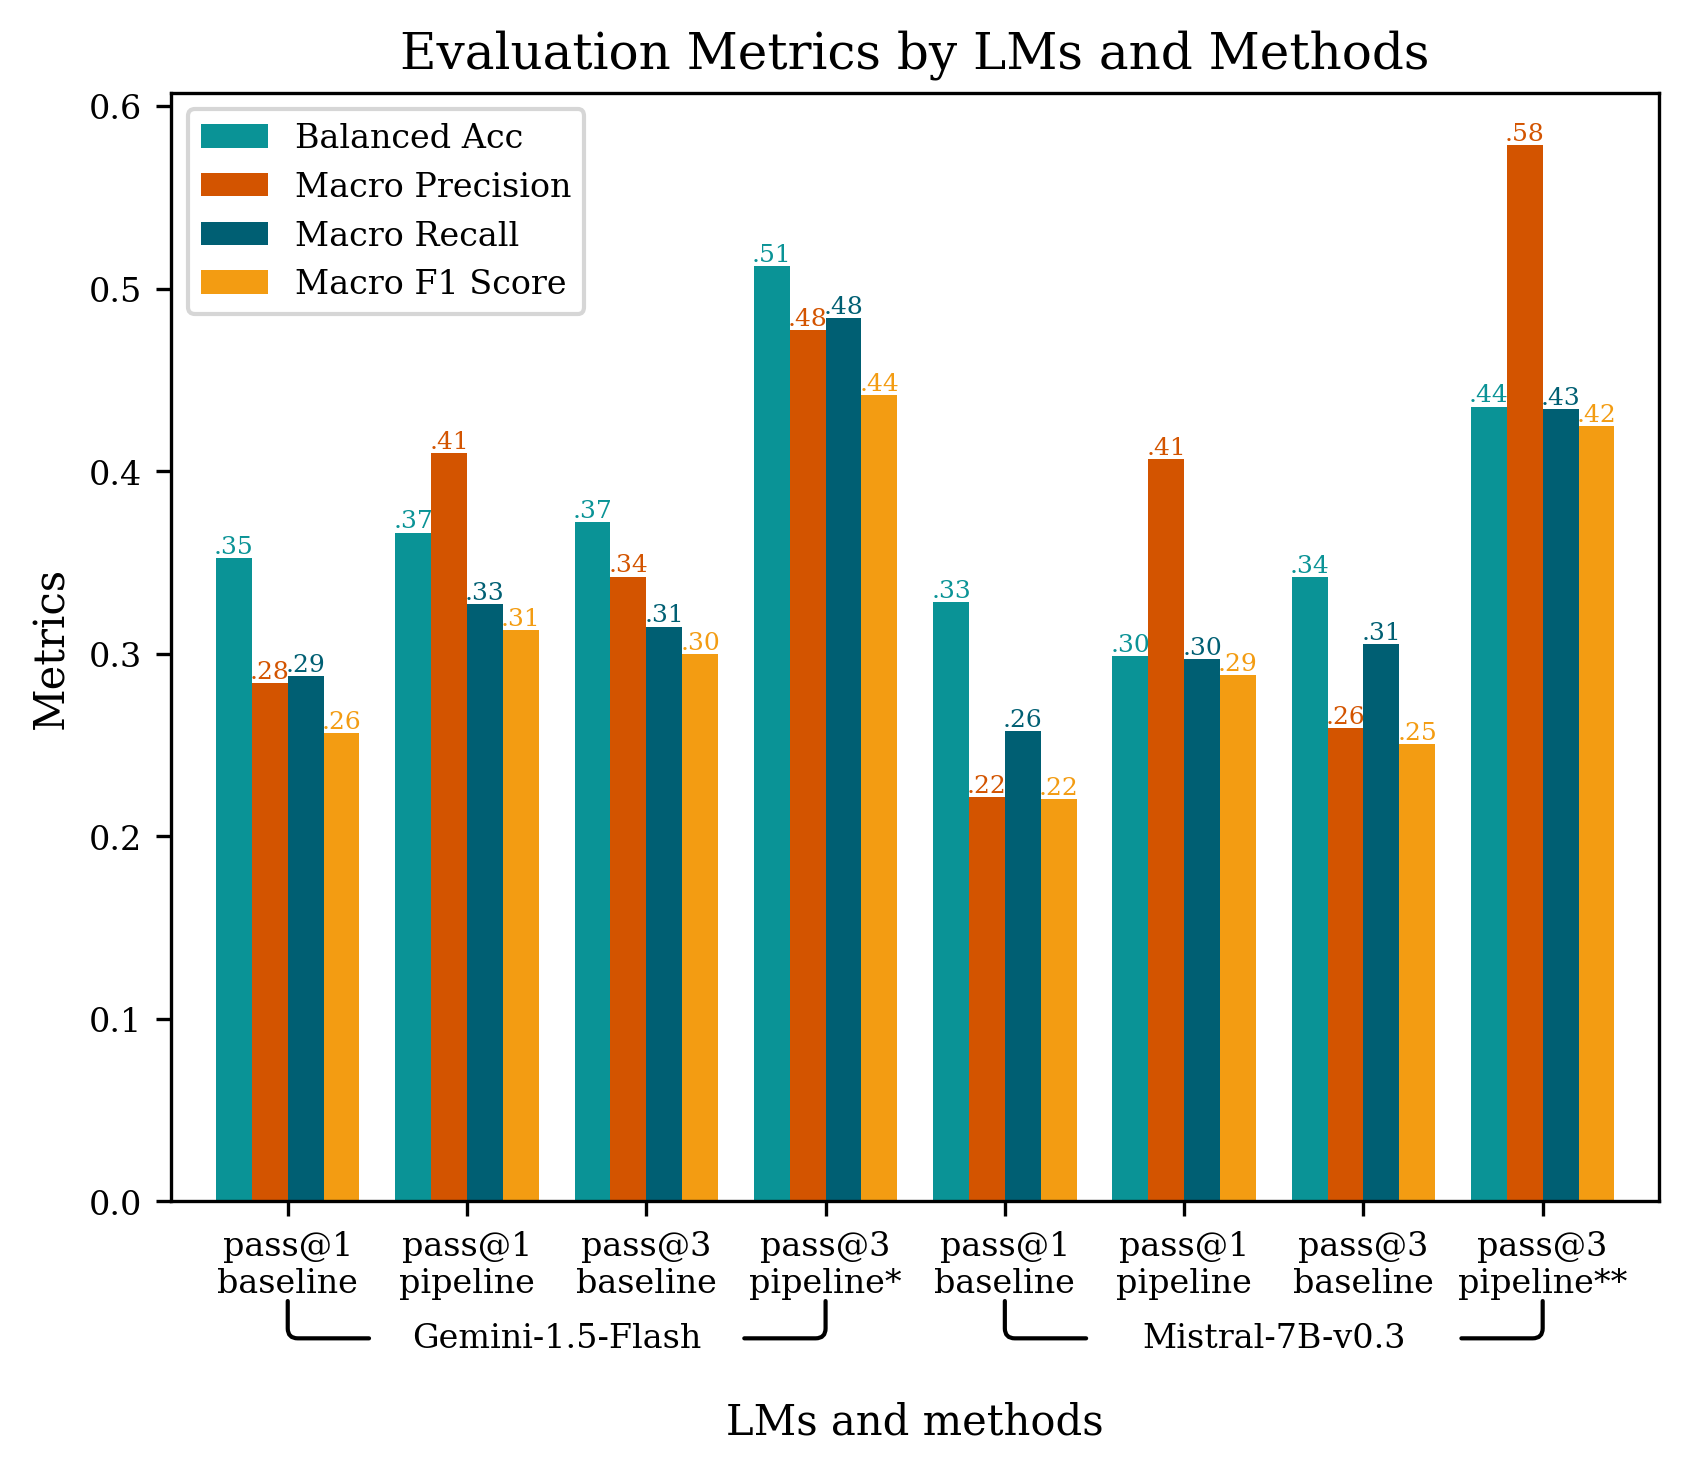

<Figure size 640x480 with 0 Axes>

In [148]:

import matplotlib.pyplot as plt 
import pandas as pd 

# Set fall color palette
fall_colors = ['#0a9396',
               '#D35400',  # Pumpkin orange
               '#005f73',   # Deep purple
               '#F39C12',]   # Golden yellow   

plt.rcParams["font.family"] = "serif"
# create data 
df = pd.DataFrame([['pass@1 baseline', acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini], 
                   ['pass@1 pipeline', acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini], 
                   ['pass@3 baseline', acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini], 
                   ['pass@3 pipeline', acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini],
                   ['pass@1 baseline_mistral', acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral], 
                   ['pass@1 pipeline_mistral', acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral], 
                   ['pass@3 baseline_mistral', acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral], 
                   ['pass@3 pipeline_mistral', acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral]], 
                  columns=['Team', 'Balanced Acc', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']) 

fig, ax = plt.subplots(dpi=300)
# plot grouped bar chart with fall colors
df.plot(kind='bar', 
        stacked=False, 
        title='',
        ax=ax,
        width=0.8,
        color=fall_colors)

for bar in ax.patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  text = f'{bar_value:.2f}'
  text = text[-3:]
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=6)
ax.set_xticks(df.index, ["pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline*",
                         "pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline**"], 
              fontsize=8,
              rotation=0)
ax.set_title('Evaluation Metrics by LMs and Methods', fontsize=12)
ax.set_ylabel('Metrics')
ax.set_xlabel('LMs and methods')
ax.xaxis.set_label_coords(0.5, -0.18)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.text(1.5, -0.08, 'Gemini-1.5-Flash', fontsize=8, ha='center')
ax.annotate('', xy=(0.5, -0.075), xytext=(0, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(2.5, -0.075), xytext=(3, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

ax.text(5.5, -0.08, 'Mistral-7B-v0.3', fontsize=8, ha='center')
ax.annotate('', xy=(4.5, -0.075), xytext=(4, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(6.5, -0.075), xytext=(7, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.legend(loc="upper left",
         facecolor='white',
         fontsize=8)

plt.show()
plt.savefig('eval.png')

In [172]:
cm_base1_gemini, acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini = generate_metrics(gemini_true, gemini_preds[0])
cm_pipe1_gemini, acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini = generate_metrics(gemini_true, gemini_preds[1])
cm_base3_gemini, acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini = generate_metrics(gemini_true, gemini_preds[2])
cm_pipe3_gemini, acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini = generate_metrics(gemini_true, gemini_preds[3])

cm_base1_mistral, acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral = generate_metrics(mistral_true, mistral_preds[0])
cm_pipe1_mistral, acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral = generate_metrics(mistral_true, mistral_preds[1])
cm_base3_mistral, acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral = generate_metrics(mistral_true, mistral_preds[2])
cm_pipe3_mistral, acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral = generate_metrics(mistral_true, mistral_preds[3])

/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _war

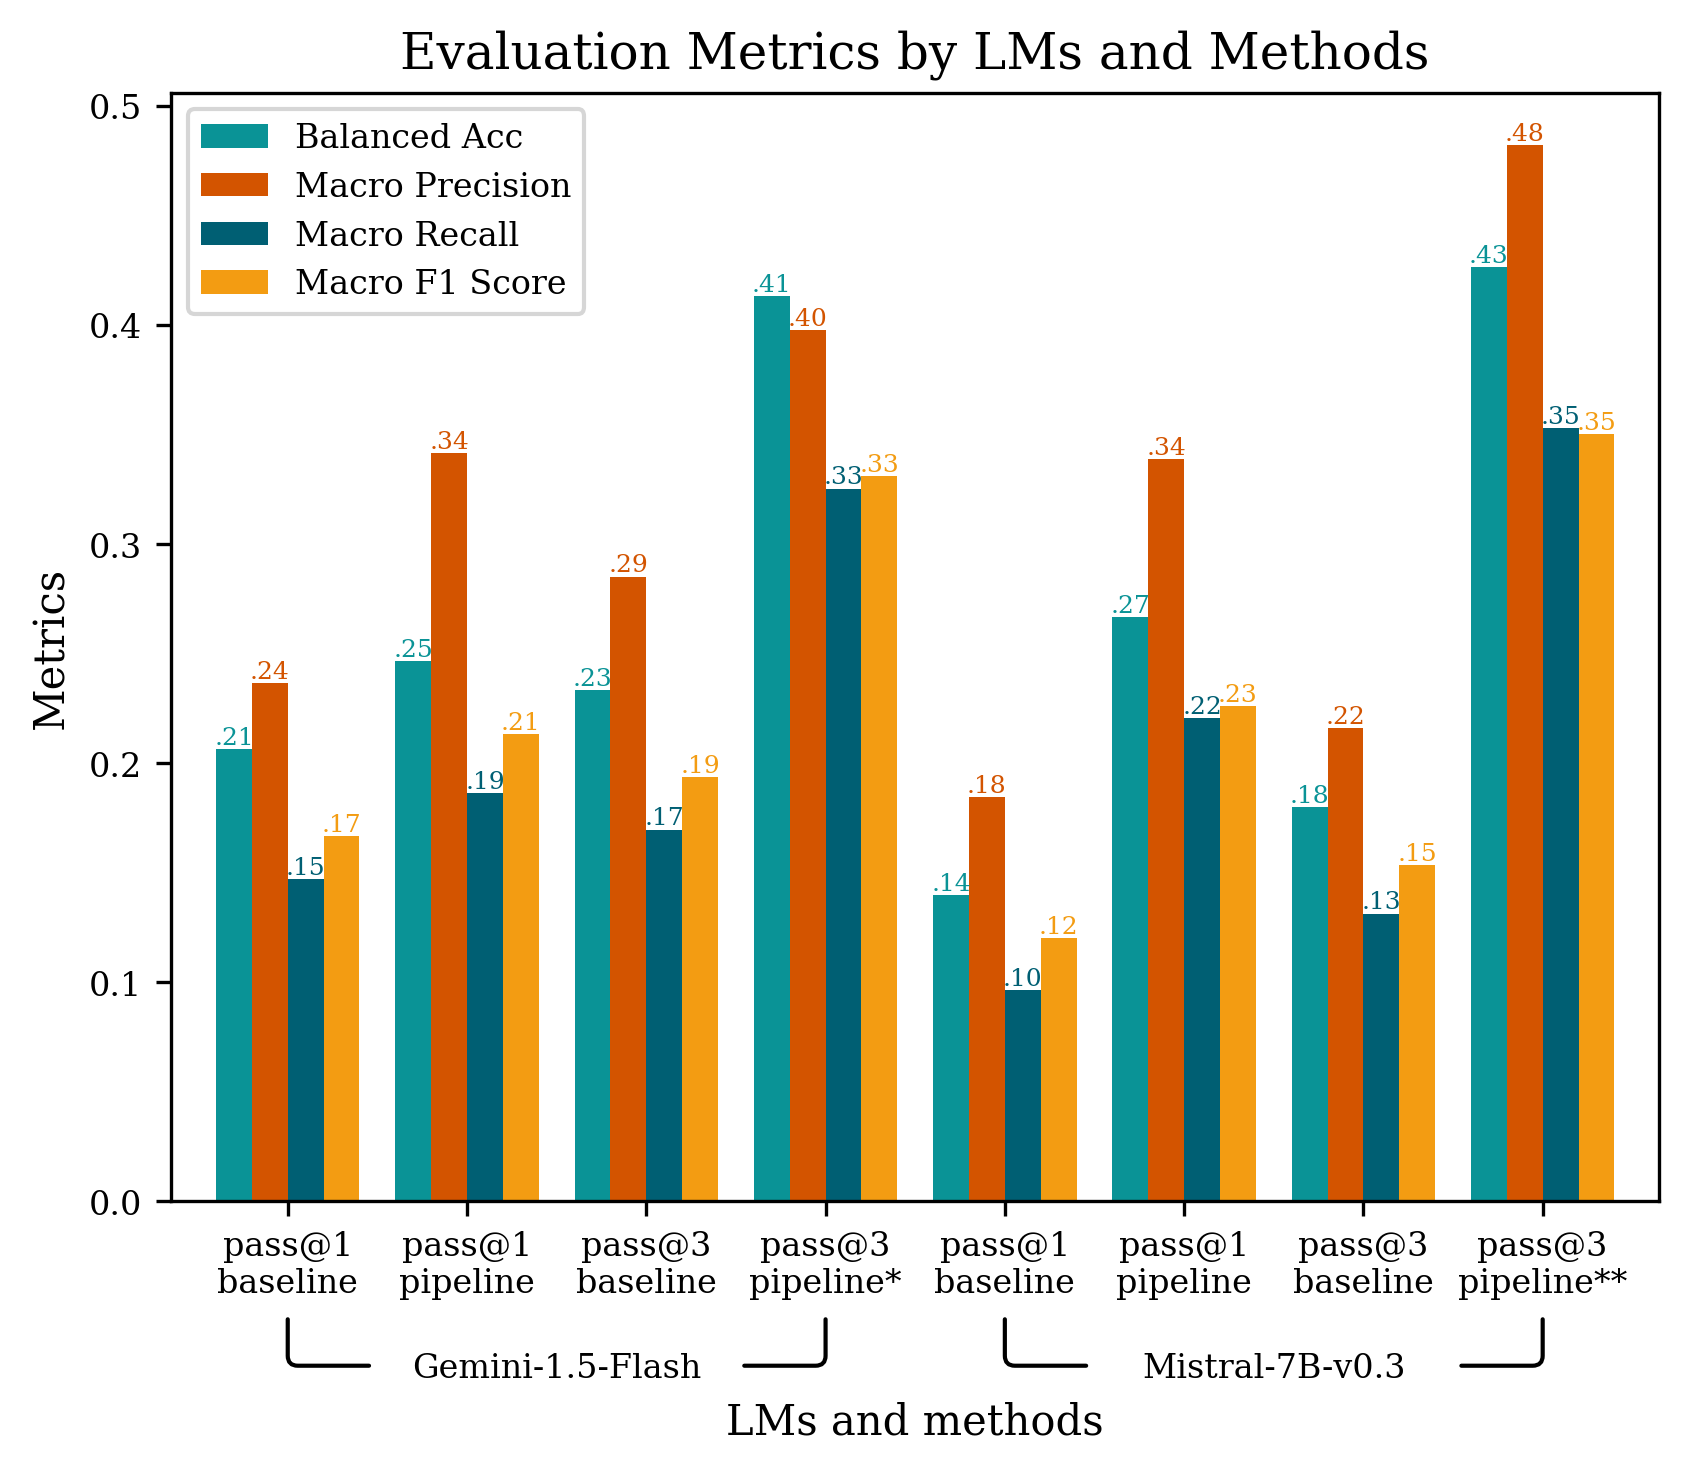

<Figure size 640x480 with 0 Axes>

In [183]:
import matplotlib.pyplot as plt 
import pandas as pd 

# Set fall color palette
fall_colors = ['#0a9396',
               '#D35400',  # Pumpkin orange
               '#005f73',   # Deep purple
               '#F39C12',]   # Golden yellow   

plt.rcParams["font.family"] = "serif"
# create data 
df = pd.DataFrame([['pass@1 baseline', acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini], 
                   ['pass@1 pipeline', acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini], 
                   ['pass@3 baseline', acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini], 
                   ['pass@3 pipeline', acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini],
                   ['pass@1 baseline_mistral', acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral], 
                   ['pass@1 pipeline_mistral', acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral], 
                   ['pass@3 baseline_mistral', acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral], 
                   ['pass@3 pipeline_mistral', acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral]], 
                  columns=['Team', 'Balanced Acc', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']) 

fig, ax = plt.subplots(dpi=300)
# plot grouped bar chart with fall colors
df.plot(kind='bar', 
        stacked=False, 
        title='',
        ax=ax,
        width=0.8,
        color=fall_colors)

for bar in ax.patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  text = f'{bar_value:.2f}'
  text = text[-3:]
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=6)
ax.set_xticks(df.index, ["pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline*",
                         "pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline**"], 
              fontsize=8,
              rotation=0)
ax.set_title('Evaluation Metrics by LMs and Methods', fontsize=12)
ax.set_ylabel('Metrics')
ax.set_xlabel('LMs and methods')
ax.xaxis.set_label_coords(0.5, -0.18)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.text(1.5, -0.08, 'Gemini-1.5-Flash', fontsize=8, ha='center')
ax.annotate('', xy=(0.5, -0.075), xytext=(0, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(2.5, -0.075), xytext=(3, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

ax.text(5.5, -0.08, 'Mistral-7B-v0.3', fontsize=8, ha='center')
ax.annotate('', xy=(4.5, -0.075), xytext=(4, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(6.5, -0.075), xytext=(7, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.legend(loc="upper left",
         facecolor='white',
         fontsize=8)

plt.show()
plt.savefig('eval.png')

                      Team  Precision    Recall  F1 Score
0          pass@1 baseline   0.358685  0.352273  0.332547
1          pass@1 pipeline   0.462763  0.366337  0.365740
2          pass@3 baseline   0.399797  0.372340  0.363558
3          pass@3 pipeline   0.515929  0.512397  0.480478
4  pass@1 baseline_mistral   0.293750  0.328125  0.296647
5  pass@1 pipeline_mistral   0.448579  0.298507  0.305832
6  pass@3 baseline_mistral   0.319023  0.341772  0.308218
7  pass@3 pipeline_mistral   0.617394  0.435374  0.444871


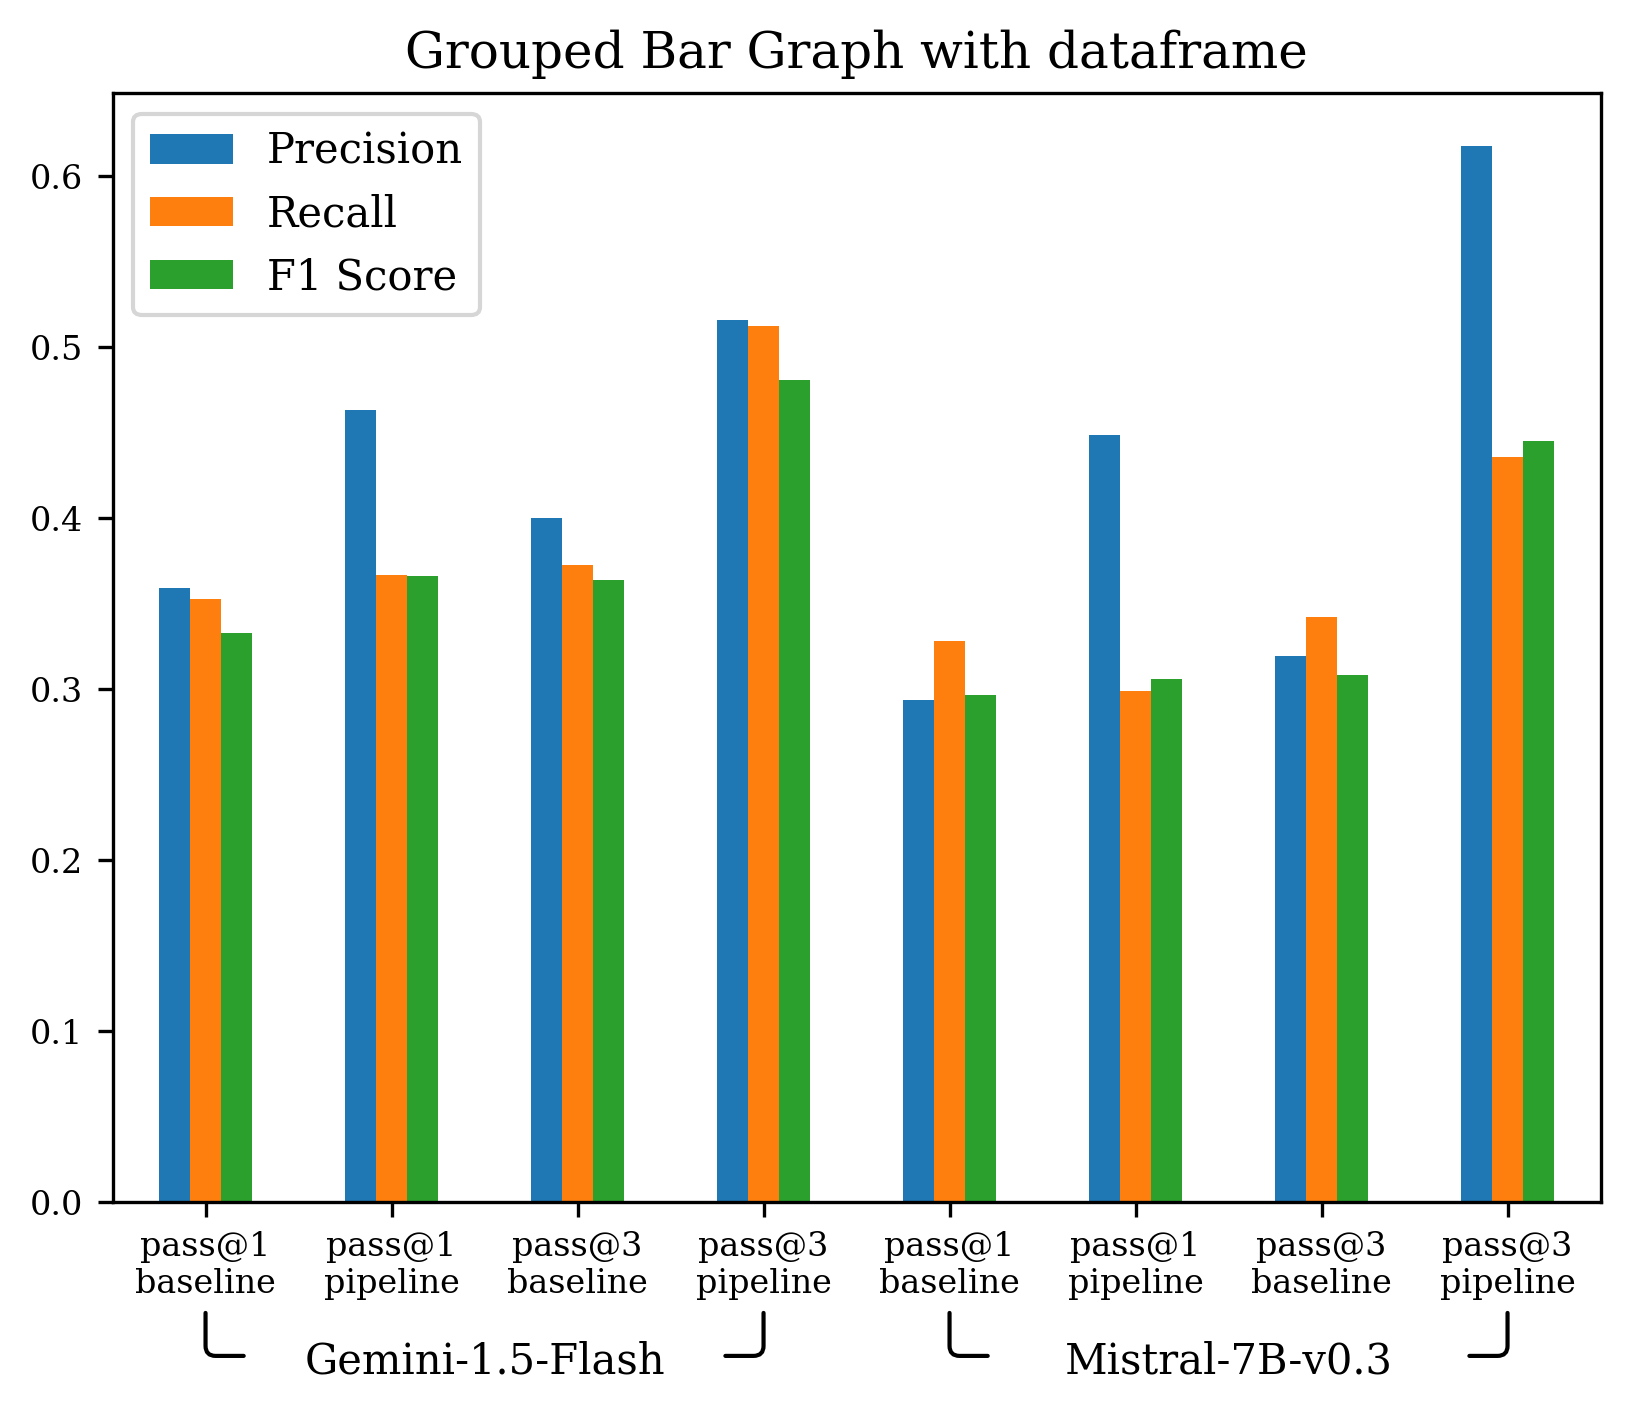

In [30]:
# importing package 
import matplotlib.pyplot as plt 
import pandas as pd 

plt.rcParams["font.family"] = "serif"
# create data 
df = pd.DataFrame([['pass@1 baseline', p_base1_gemini, r_base1_gemini, f1_base1_gemini], 
                   ['pass@1 pipeline', p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini], 
                   ['pass@3 baseline', p_base3_gemini, r_base3_gemini, f1_base3_gemini], 
                   ['pass@3 pipeline', p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini],
                   ['pass@1 baseline_mistral', p_base1_mistral, r_base1_mistral, f1_base1_mistral], 
                   ['pass@1 pipeline_mistral', p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral], 
                   ['pass@3 baseline_mistral', p_base3_mistral, r_base3_mistral, f1_base3_mistral], 
                   ['pass@3 pipeline_mistral', p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral]], 
                  columns=['Team', 'Precision', 'Recall', 'F1 Score']) 
# view data 
print(df) 
  
fig, ax = plt.subplots(dpi=300)
# plot grouped bar chart 
df.plot(kind='bar', 
        stacked=False, 
        title='Grouped Bar Graph with dataframe',ax=ax)
ax.set_xticks(df.index, ["pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline","pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline"], 
              fontsize=8,
              rotation=0)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.text(1.5, -0.1, 'Gemini-1.5-Flash', fontsize = 10, ha='center')
ax.annotate('', xy=(0.25, -0.09), xytext=(0, -0.06), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(2.75, -0.09), xytext=(3, -0.06), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

ax.text(5.5, -0.1, 'Mistral-7B-v0.3', fontsize = 10, ha='center')
ax.annotate('', xy=(4.25, -0.09), xytext=(4, -0.06), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(6.75, -0.09), xytext=(7, -0.06), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.legend(loc="upper left",
          facecolor='white')
plt.show()

[<BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>] ['Precision', 'Recall', 'F1 Score']


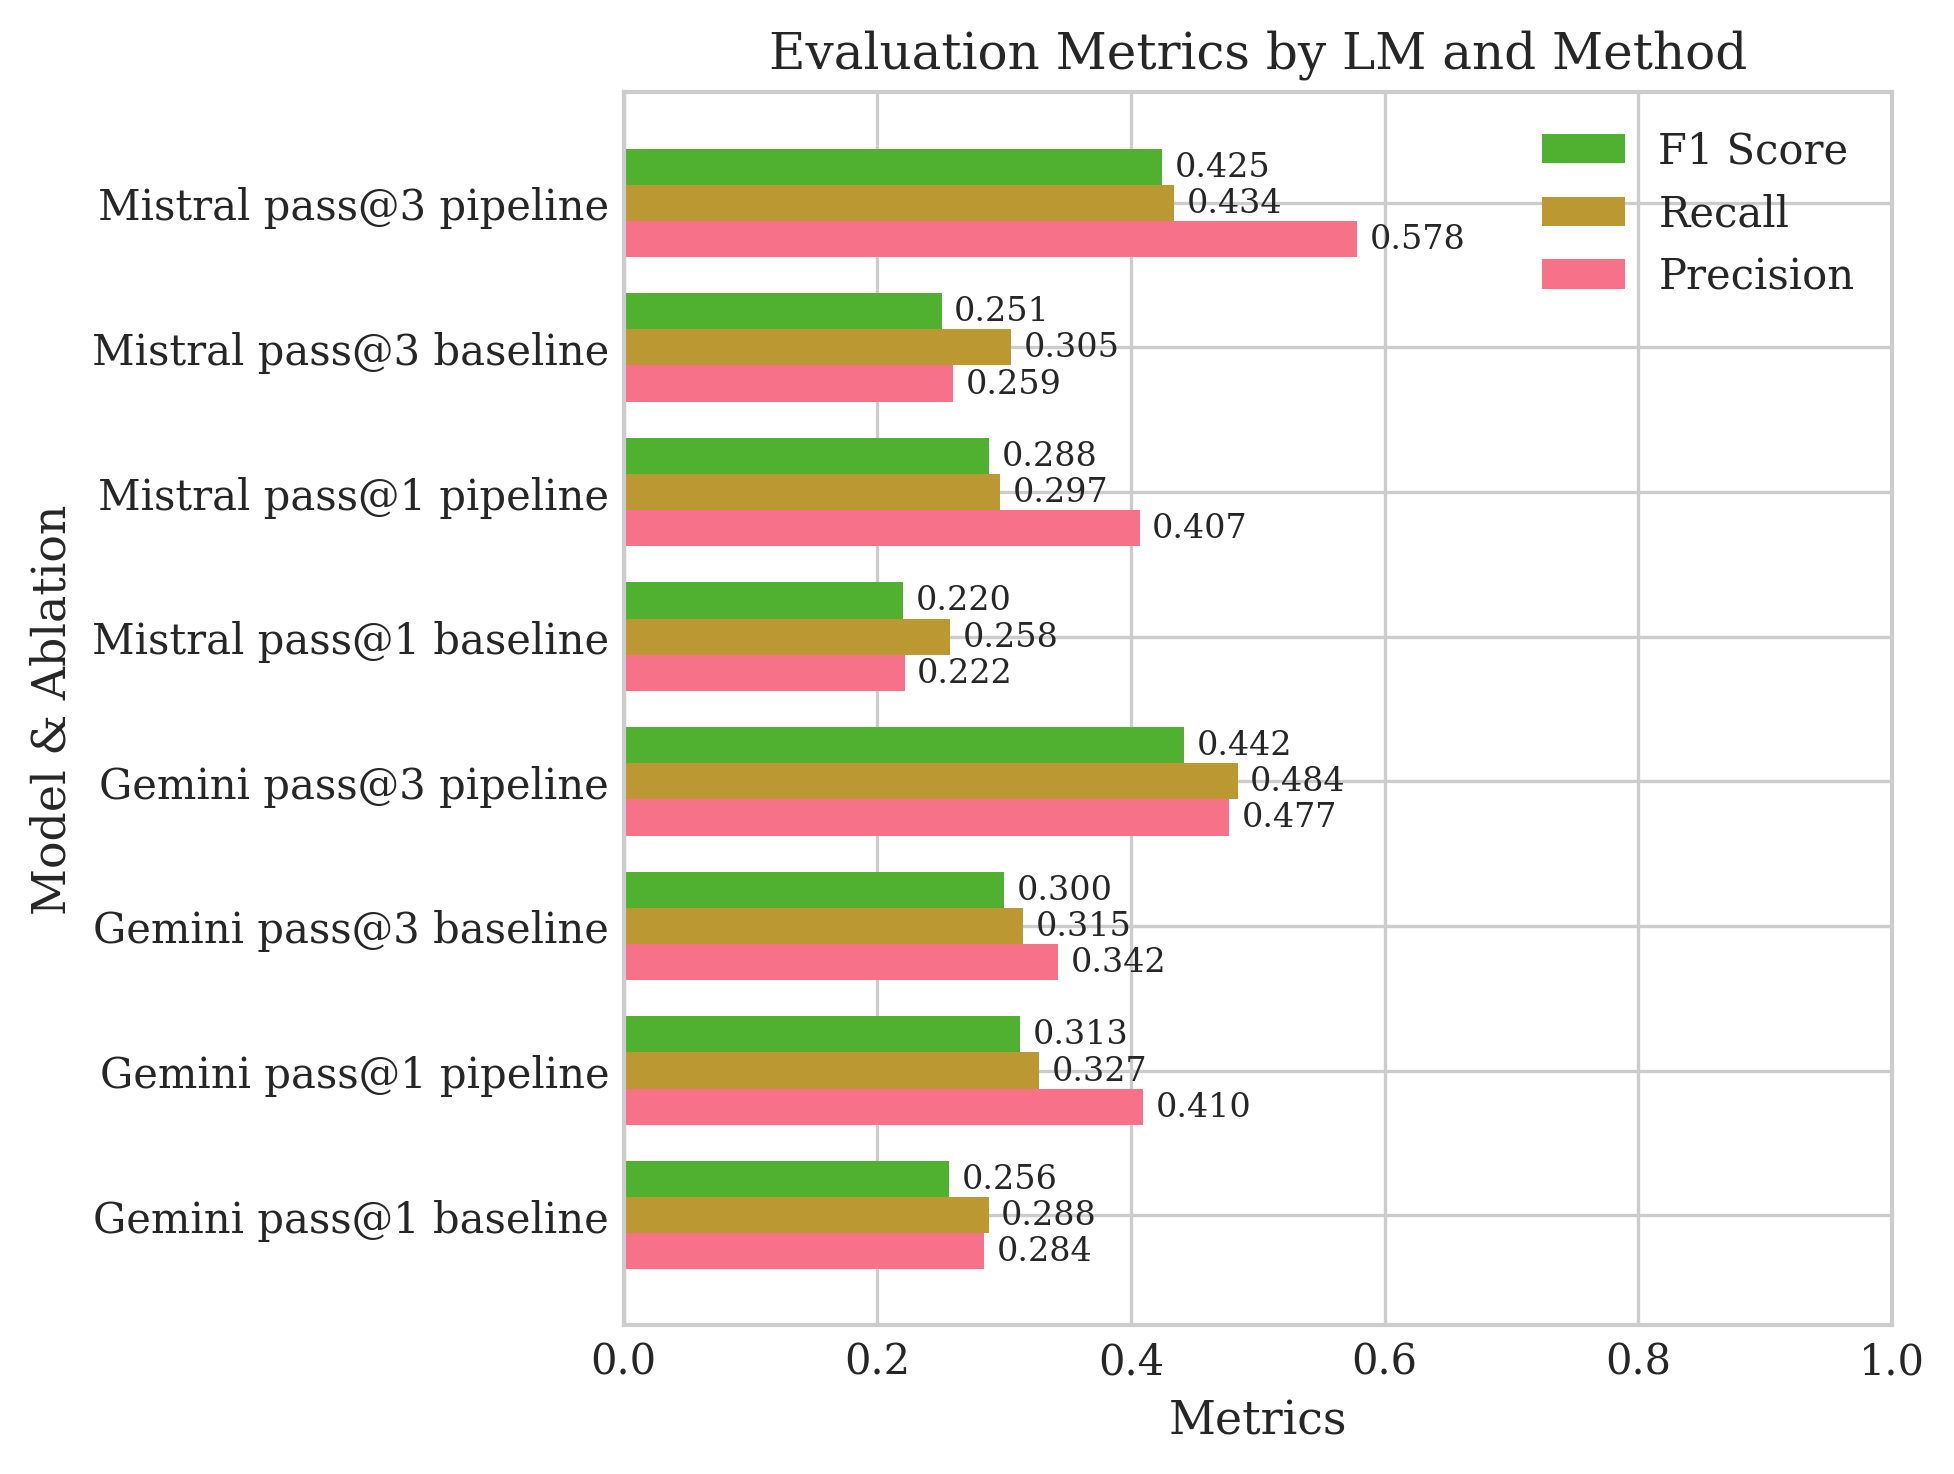

In [402]:
labels = ['Gemini pass@1 baseline', 'Gemini pass@1 pipeline' , 'Gemini pass@3 baseline', 'Gemini pass@3 pipeline',
          'Mistral pass@1 baseline', 'Mistral pass@1 pipeline' , 'Mistral pass@3 baseline', 'Mistral pass@3 pipeline']
metrics = {
    'Precision': (p_base1_gemini, p_pipe1_gemini, p_base3_gemini, p_pipe3_gemini,
                  p_base1_mistral, p_pipe1_mistral, p_base3_mistral, p_pipe3_mistral),
    'Recall': (r_base1_gemini, r_pipe1_gemini, r_base3_gemini, r_pipe3_gemini,
               r_base1_mistral, r_pipe1_mistral, r_base3_mistral, r_pipe3_mistral),
    'F1 Score': (f1_base1_gemini, f1_pipe1_gemini, f1_base3_gemini, f1_pipe3_gemini,
               f1_base1_mistral, f1_pipe1_mistral, f1_base3_mistral, f1_pipe3_mistral),
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in metrics.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.3f', fontsize = 8)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model & Ablation')
ax.set_xlabel('Metrics')
ax.set_title('Evaluation Metrics by LM and Method')
ax.set_yticks(x + width, labels, ha = 'right')
ax.set_xlim(0, 1)
# ax.set_ylim(0, 250)

handles, labels = plt.gca().get_legend_handles_labels()
print(handles, labels)
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

Counter()

In [395]:
from collections import Counter
print(Counter(gemini))

Counter({0: 56, 2: 39, 1: 28, 4: 22, 5: 5})


In [99]:
acc_pipe3_gemini

0.41333333333333333

In [98]:
from sklearn.metrics import classification_report

y_true = ['Airplane', 'Car', 'Car', 'Car', 'Car', 'Airplane', 'Boat', 'Car', 'Airplane', 'Car']
y_pred = ['Airplane', 'Boat', 'Car', 'Car', 'Boat', 'Boat', 'Boat', 'Airplane', 'Airplane', 'Car']
print(classification_report(gemini_true, gemini_preds[3]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.76      0.62      0.68        42
           2       0.40      0.52      0.45        27
           3       0.00      0.00      0.00        27
           4       0.33      0.52      0.41        27
           5       0.89      0.30      0.44        27

    accuracy                           0.41       150
   macro avg       0.40      0.33      0.33       150
weighted avg       0.51      0.41      0.43       150



/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [398]:
print(classification_report(gemini_cohen_true[1], gemini_cohen_pred[1]))

              precision    recall  f1-score   support

           1       0.66      0.56      0.60        34
           2       0.19      0.33      0.24        18
           3       0.00      0.00      0.00        16
           4       0.21      0.47      0.29        15
           5       1.00      0.28      0.43        18

    accuracy                           0.37       101
   macro avg       0.41      0.33      0.31       101
weighted avg       0.46      0.37      0.37       101



In [400]:
print(classification_report(gemini_cohen_true[2], gemini_cohen_pred[2]))

              precision    recall  f1-score   support

           1       0.75      0.66      0.70        32
           2       0.18      0.44      0.25        16
           3       0.00      0.00      0.00        17
           4       0.18      0.25      0.21        16
           5       0.60      0.23      0.33        13

    accuracy                           0.37        94
   macro avg       0.34      0.31      0.30        94
weighted avg       0.40      0.37      0.36        94



/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [399]:
print(classification_report(gemini_cohen_true[3], gemini_cohen_pred[3]))

              precision    recall  f1-score   support

           1       0.76      0.70      0.73        37
           2       0.40      0.64      0.49        22
           3       0.00      0.00      0.00        21
           4       0.33      0.70      0.45        20
           5       0.89      0.38      0.53        21

    accuracy                           0.51       121
   macro avg       0.48      0.48      0.44       121
weighted avg       0.52      0.51      0.48       121



In [ ]:
gemini_df = map_df('gemini')


Top 5 statements with highest pipeline pass@1 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass1_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
38,"Tim Walz said he carried weapons in war, but “...",TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY FALSE]",9.0
119,"“Remember in 2020, 55 of the biggest companies...",FALSE,"[MOSTLY TRUE, MOSTLY FALSE, MOSTLY TRUE]",9.0
13,Says opponent Eric Hovde “supports a $4 trilli...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY TRUE]",4.0
18,“There was a bill to basically create a ban to...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, UNVERIFIABLE]",4.0



Top 5 statements with highest pipeline pass@3 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass3_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
32,“Dave McCormick is fully against abortion.”,MOSTLY FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",4.0
35,"“400,000 workers are now in a union that were ...",MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, UNVERIFIABLE]",4.0
41,"“Even before the pandemic, America went into a...",MOSTLY TRUE,"[UNVERIFIABLE, UNVERIFIABLE, MOSTLY FALSE]",4.0
115,"""[The Trump Administration] added more to the ...",HALF TRUE,"[UNVERIFIABLE, FALSE, UNVERIFIABLE]",4.0


In [ ]:
# importing package 
import matplotlib.pyplot as plt 
import pandas as pd 

  
# create data 
df = pd.DataFrame([['A', 10, 20, 10, 30], ['B', 20, 25, 15, 25], ['C', 12, 15, 19, 6], 
                   ['D', 10, 29, 13, 19]], 
                  columns=['Team', 'Round 1', 'Round 2', 'Round 3', 'Round 4']) 
# view data 
print(df) 
  
# plot grouped bar chart 
df.plot(x='Team', 
        kind='bar', 
        stacked=False, 
        title='Grouped Bar Graph with dataframe') 

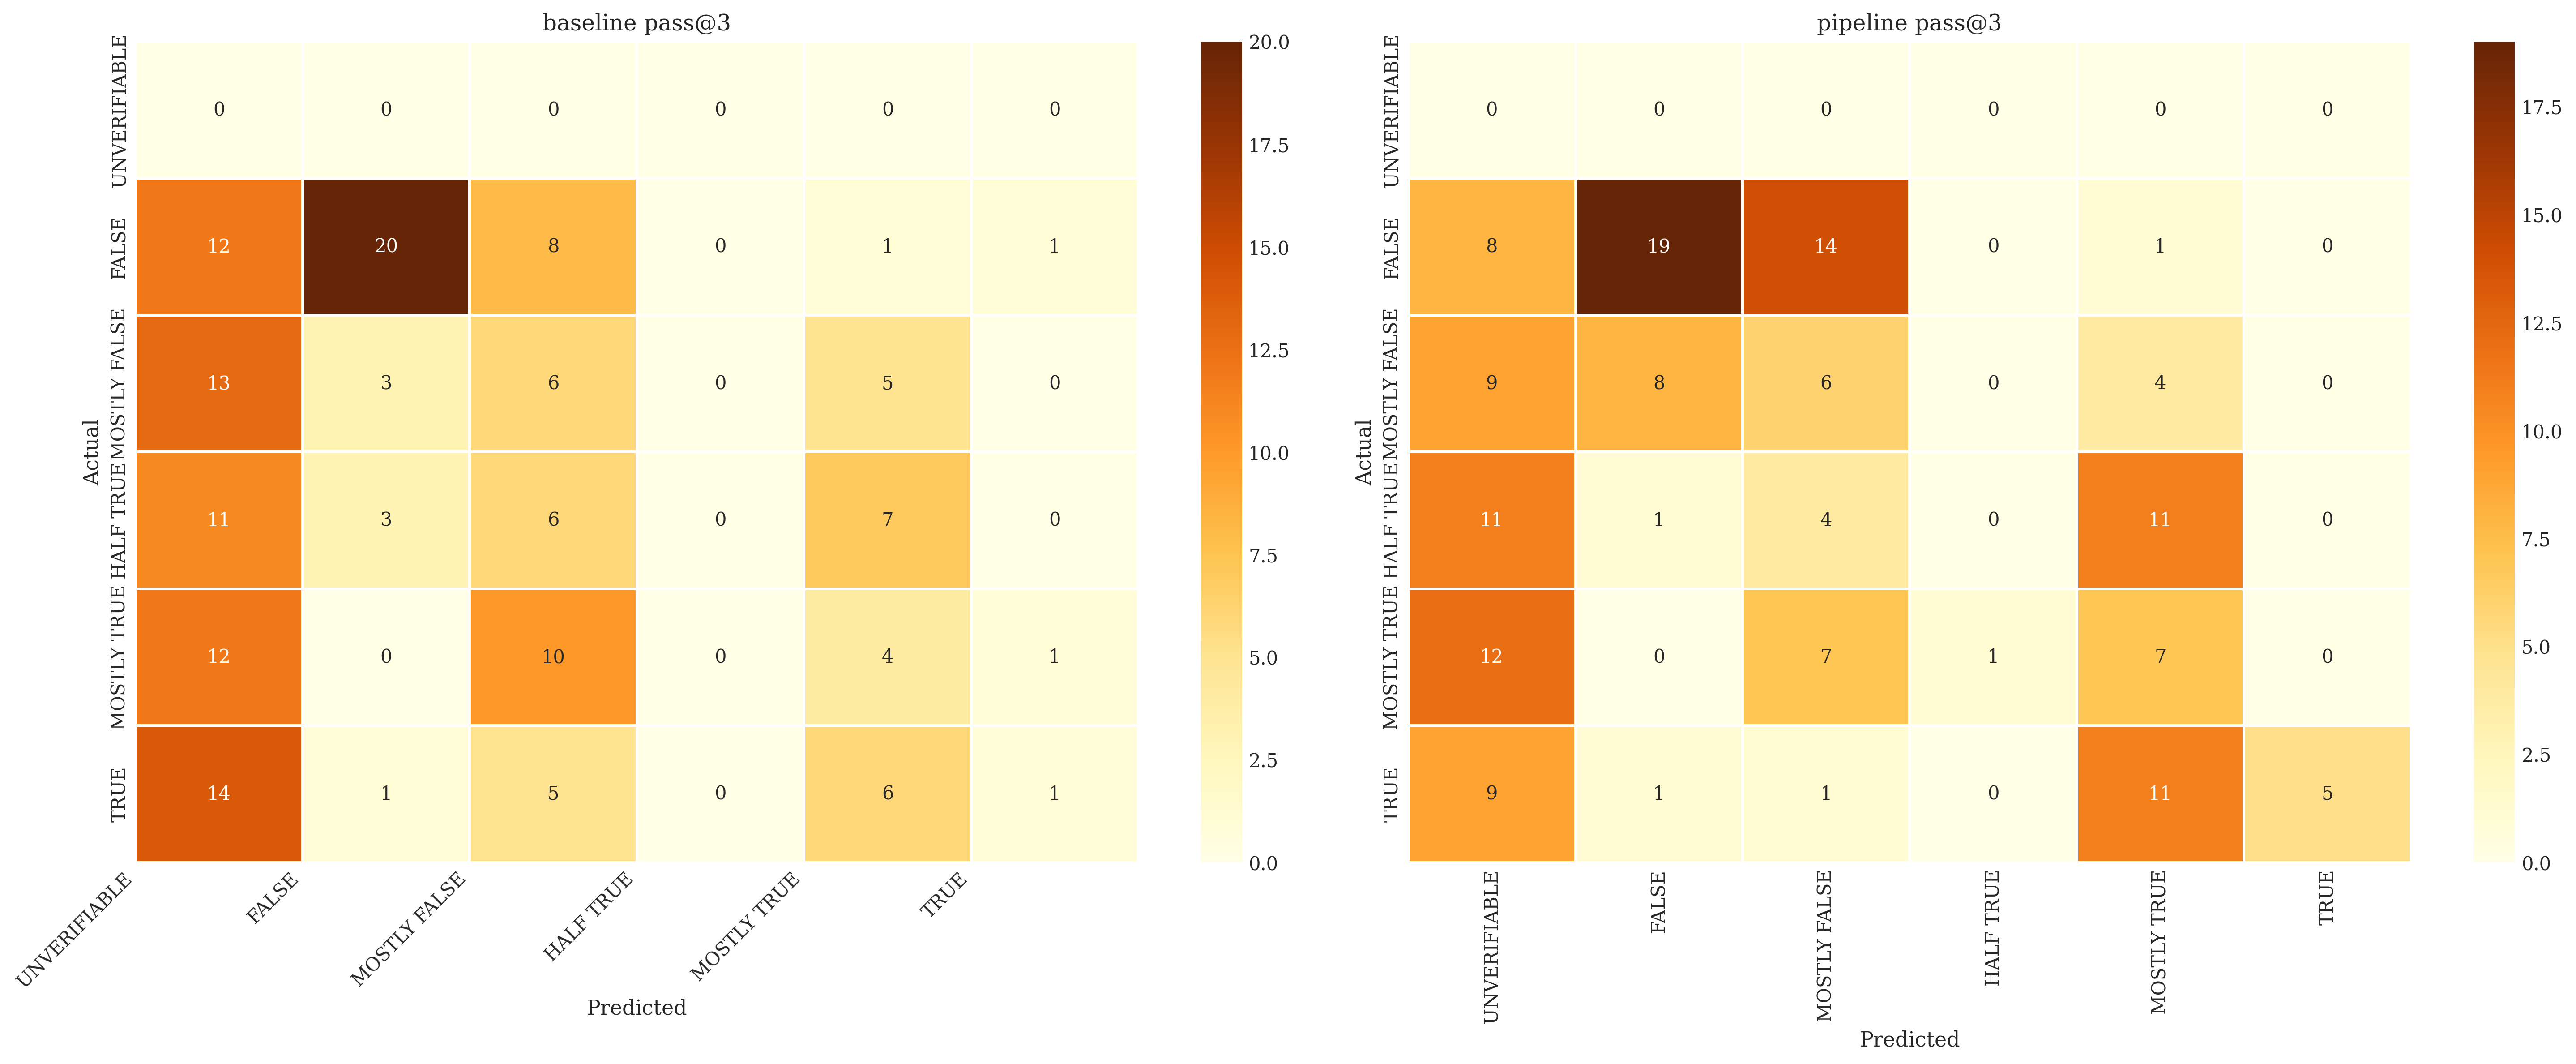

In [369]:
import matplotlib.pyplot as plt
import seaborn as sns
verdicts = ['UNVERIFIABLE','FALSE','MOSTLY FALSE','HALF TRUE','MOSTLY TRUE','TRUE']
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
plt.rcParams['figure.dpi'] = 300
ax = sns.heatmap(cm_base1_gemini, linewidths=1, ax = axes[0], annot=True, fmt='', cmap='YlOrBr',
                 yticklabels=['UNVERIFIABLE','FALSE','MOSTLY FALSE','HALF TRUE','MOSTLY TRUE','TRUE'])
ax.set_xticks(range(len(verdicts)), labels=verdicts , rotation=45, ha="right")
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'baseline pass@3')

ax = sns.heatmap(cm_pipe1_gemini, linewidths=1, ax = axes[1], annot=True, fmt='', cmap='YlOrBr', 
                 xticklabels=['UNVERIFIABLE','FALSE','MOSTLY FALSE','HALF TRUE','MOSTLY TRUE','TRUE'],
                 yticklabels=['UNVERIFIABLE','FALSE','MOSTLY FALSE','HALF TRUE','MOSTLY TRUE','TRUE'],)
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'pipeline pass@3')
fig.tight_layout(pad=1.0) 

plt.show()


In [58]:
from pycm import *

In [60]:
cm_1 = ConfusionMatrix(gemini_true, gemini_preds[0],digit=5)

In [45]:
gemini_cohen_dict

{'pass@1_base': 0.17227722772277243,
 'pass@1_pipe': 0.1943163405210021,
 'pass@3_base': 0.19611537904044063,
 'pass@3_pipe': 0.3825996713655625}

## MSE

In [113]:
# Extract the first (pass@1) and best of 3 (pass@3) verdicts
# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "PANTS ON FIRE": 1, # Pants on fire is the same as false
    "MOSTLY UNVERIFIABLE": 0,
    "INDIFFERENT": 0,
    'MOSTLY HALF TRUE': 4,
    'PARTIALLY TRUE': 3,
}

def map_df(model):
    df = pd.read_pickle(f'results_v2_{model}.pkl')

    # Extract the verdicts from the results columns
    df['pred_verdicts_baseline'] = df[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
    df['pred_verdicts_pipeline'] = df[f'{model}_pipeline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

    # Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
    # "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
    # 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
    for i, row in df.iterrows():
        cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
        for col in cols: 
            verdicts = row[col]
            if verdicts:
                verdicts = [v.split(':')[0].split('-')[0].split('(')[0].split('.')[0].strip() if len(v) > 12 else v for v in verdicts]
            df.at[i, col] = verdicts

    df.dropna(subset=['pred_verdicts_pipeline', 'pred_verdicts_baseline'], inplace=True)

    df[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

    for i in range(len(df)):
        true_val = VERDICT_MAP[df.iloc[i]['verdict']]
        
        # Get pass@1 predictions
        baseline_pred = df['pred_verdicts_baseline'][i][0]
        pipeline_pred = df['pred_verdicts_pipeline'][i][0]
        # Set pass@1 predictions to its own column
        df.at[i, 'baseline_pass1_verdict'] = baseline_pred
        df.at[i, 'pipeline_pass1_verdict'] = pipeline_pred

        # Calculate pass@1 errors
        df.at[i, 'baseline_pass1_MSE'] = (true_val - VERDICT_MAP[baseline_pred])**2 if baseline_pred != "UNVERIFIABLE" else None
        df.at[i, 'pipeline_pass1_MSE'] = (true_val - VERDICT_MAP[pipeline_pred])**2 if pipeline_pred != "UNVERIFIABLE" else None
        
        # Get pass@3 predictions
        sorted_baseline_results = sorted(df.at[i, 'pred_verdicts_baseline'], key=lambda x: (VERDICT_MAP[x] - VERDICT_MAP[df.at[i, 'verdict']])**2 if x != 'UNVERIFIABLE' else 100)
        sorted_pipeline_results = sorted(df.at[i, 'pred_verdicts_pipeline'], key=lambda x: (VERDICT_MAP[x] - VERDICT_MAP[df.at[i, 'verdict']])**2 if x != 'UNVERIFIABLE' else 100)
        best_baseline_pred = sorted_baseline_results[0]
        best_pipeline_pred = sorted_pipeline_results[0]

        # Set pass@3 predictions
        df.at[i, 'baseline_pass3_verdict'] = best_baseline_pred
        df.at[i, 'pipeline_pass3_verdict'] = best_pipeline_pred
        
        # Set pass@3 errors
        df.at[i, 'baseline_pass3_MSE'] = (true_val - VERDICT_MAP[best_baseline_pred])**2 if best_baseline_pred != "UNVERIFIABLE" else None
        df.at[i, 'pipeline_pass3_MSE'] = (true_val - VERDICT_MAP[best_pipeline_pred])**2 if best_pipeline_pred != "UNVERIFIABLE" else None

    # Now you can sort by errors, for example:
    print("\nTop 5 statements with highest pipeline pass@1 errors:")
    display(df.nlargest(5, 'pipeline_pass1_MSE')[['statement', 'verdict', 'pred_verdicts_pipeline', 'pipeline_pass1_MSE']])

    print("\nTop 5 statements with highest pipeline pass@3 errors:")
    display(df.nlargest(5, 'pipeline_pass3_MSE')[['statement', 'verdict', 'pred_verdicts_pipeline', 'pipeline_pass3_MSE']])

    return df

In [114]:
gemini_df = map_df('gemini')


Top 5 statements with highest pipeline pass@1 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass1_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
38,"Tim Walz said he carried weapons in war, but “...",TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY FALSE]",9.0
119,"“Remember in 2020, 55 of the biggest companies...",FALSE,"[MOSTLY TRUE, MOSTLY FALSE, MOSTLY TRUE]",9.0
13,Says opponent Eric Hovde “supports a $4 trilli...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY TRUE]",4.0
18,“There was a bill to basically create a ban to...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, UNVERIFIABLE]",4.0



Top 5 statements with highest pipeline pass@3 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass3_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
32,“Dave McCormick is fully against abortion.”,MOSTLY FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",4.0
35,"“400,000 workers are now in a union that were ...",MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, UNVERIFIABLE]",4.0
41,"“Even before the pandemic, America went into a...",MOSTLY TRUE,"[UNVERIFIABLE, UNVERIFIABLE, MOSTLY FALSE]",4.0
115,"""[The Trump Administration] added more to the ...",HALF TRUE,"[UNVERIFIABLE, FALSE, UNVERIFIABLE]",4.0


In [115]:
mistral_df = map_df('mistral')


Top 5 statements with highest pipeline pass@1 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass1_MSE
108,"""Pharmaceutical medicine has its place, but no...",FALSE,"[MOSTLY TRUE, MOSTLY TRUE, MOSTLY FALSE]",9.0
123,"""We’ve had 12 elections in 24 years in Wiscons...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]",9.0
132,"""In February 2024, Nikki Haley lost the Nevada...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, FALSE]",9.0
138,"""Former U.S. President Donald Trump's margin o...",FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",9.0
4,“The Universities of Wisconsin are 43rd out of...,TRUE,"[HALF TRUE, MOSTLY TRUE, MOSTLY TRUE]",4.0



Top 5 statements with highest pipeline pass@3 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass3_MSE
123,"""We’ve had 12 elections in 24 years in Wiscons...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]",9.0
132,"""In February 2024, Nikki Haley lost the Nevada...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, FALSE]",9.0
138,"""Former U.S. President Donald Trump's margin o...",FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",9.0
29,"“Less than three months ago, Kamala Harris and...",MOSTLY FALSE,"[MOSTLY TRUE, UNVERIFIABLE, MOSTLY TRUE]",4.0
31,"""Typically you have three to four debates in a...",MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]",4.0


(Baseline: n=89/150, excluded 61 unverifiable) (Pipeline: n=101/150, excluded 49 unverifiable)
(Baseline: n=96/150, excluded 54 unverifiable) (Pipeline: n=121/150, excluded 29 unverifiable)
(Baseline: n=72/150, excluded 78 unverifiable) (Pipeline: n=135/150, excluded 15 unverifiable)
(Baseline: n=89/150, excluded 61 unverifiable) (Pipeline: n=147/150, excluded 3 unverifiable)


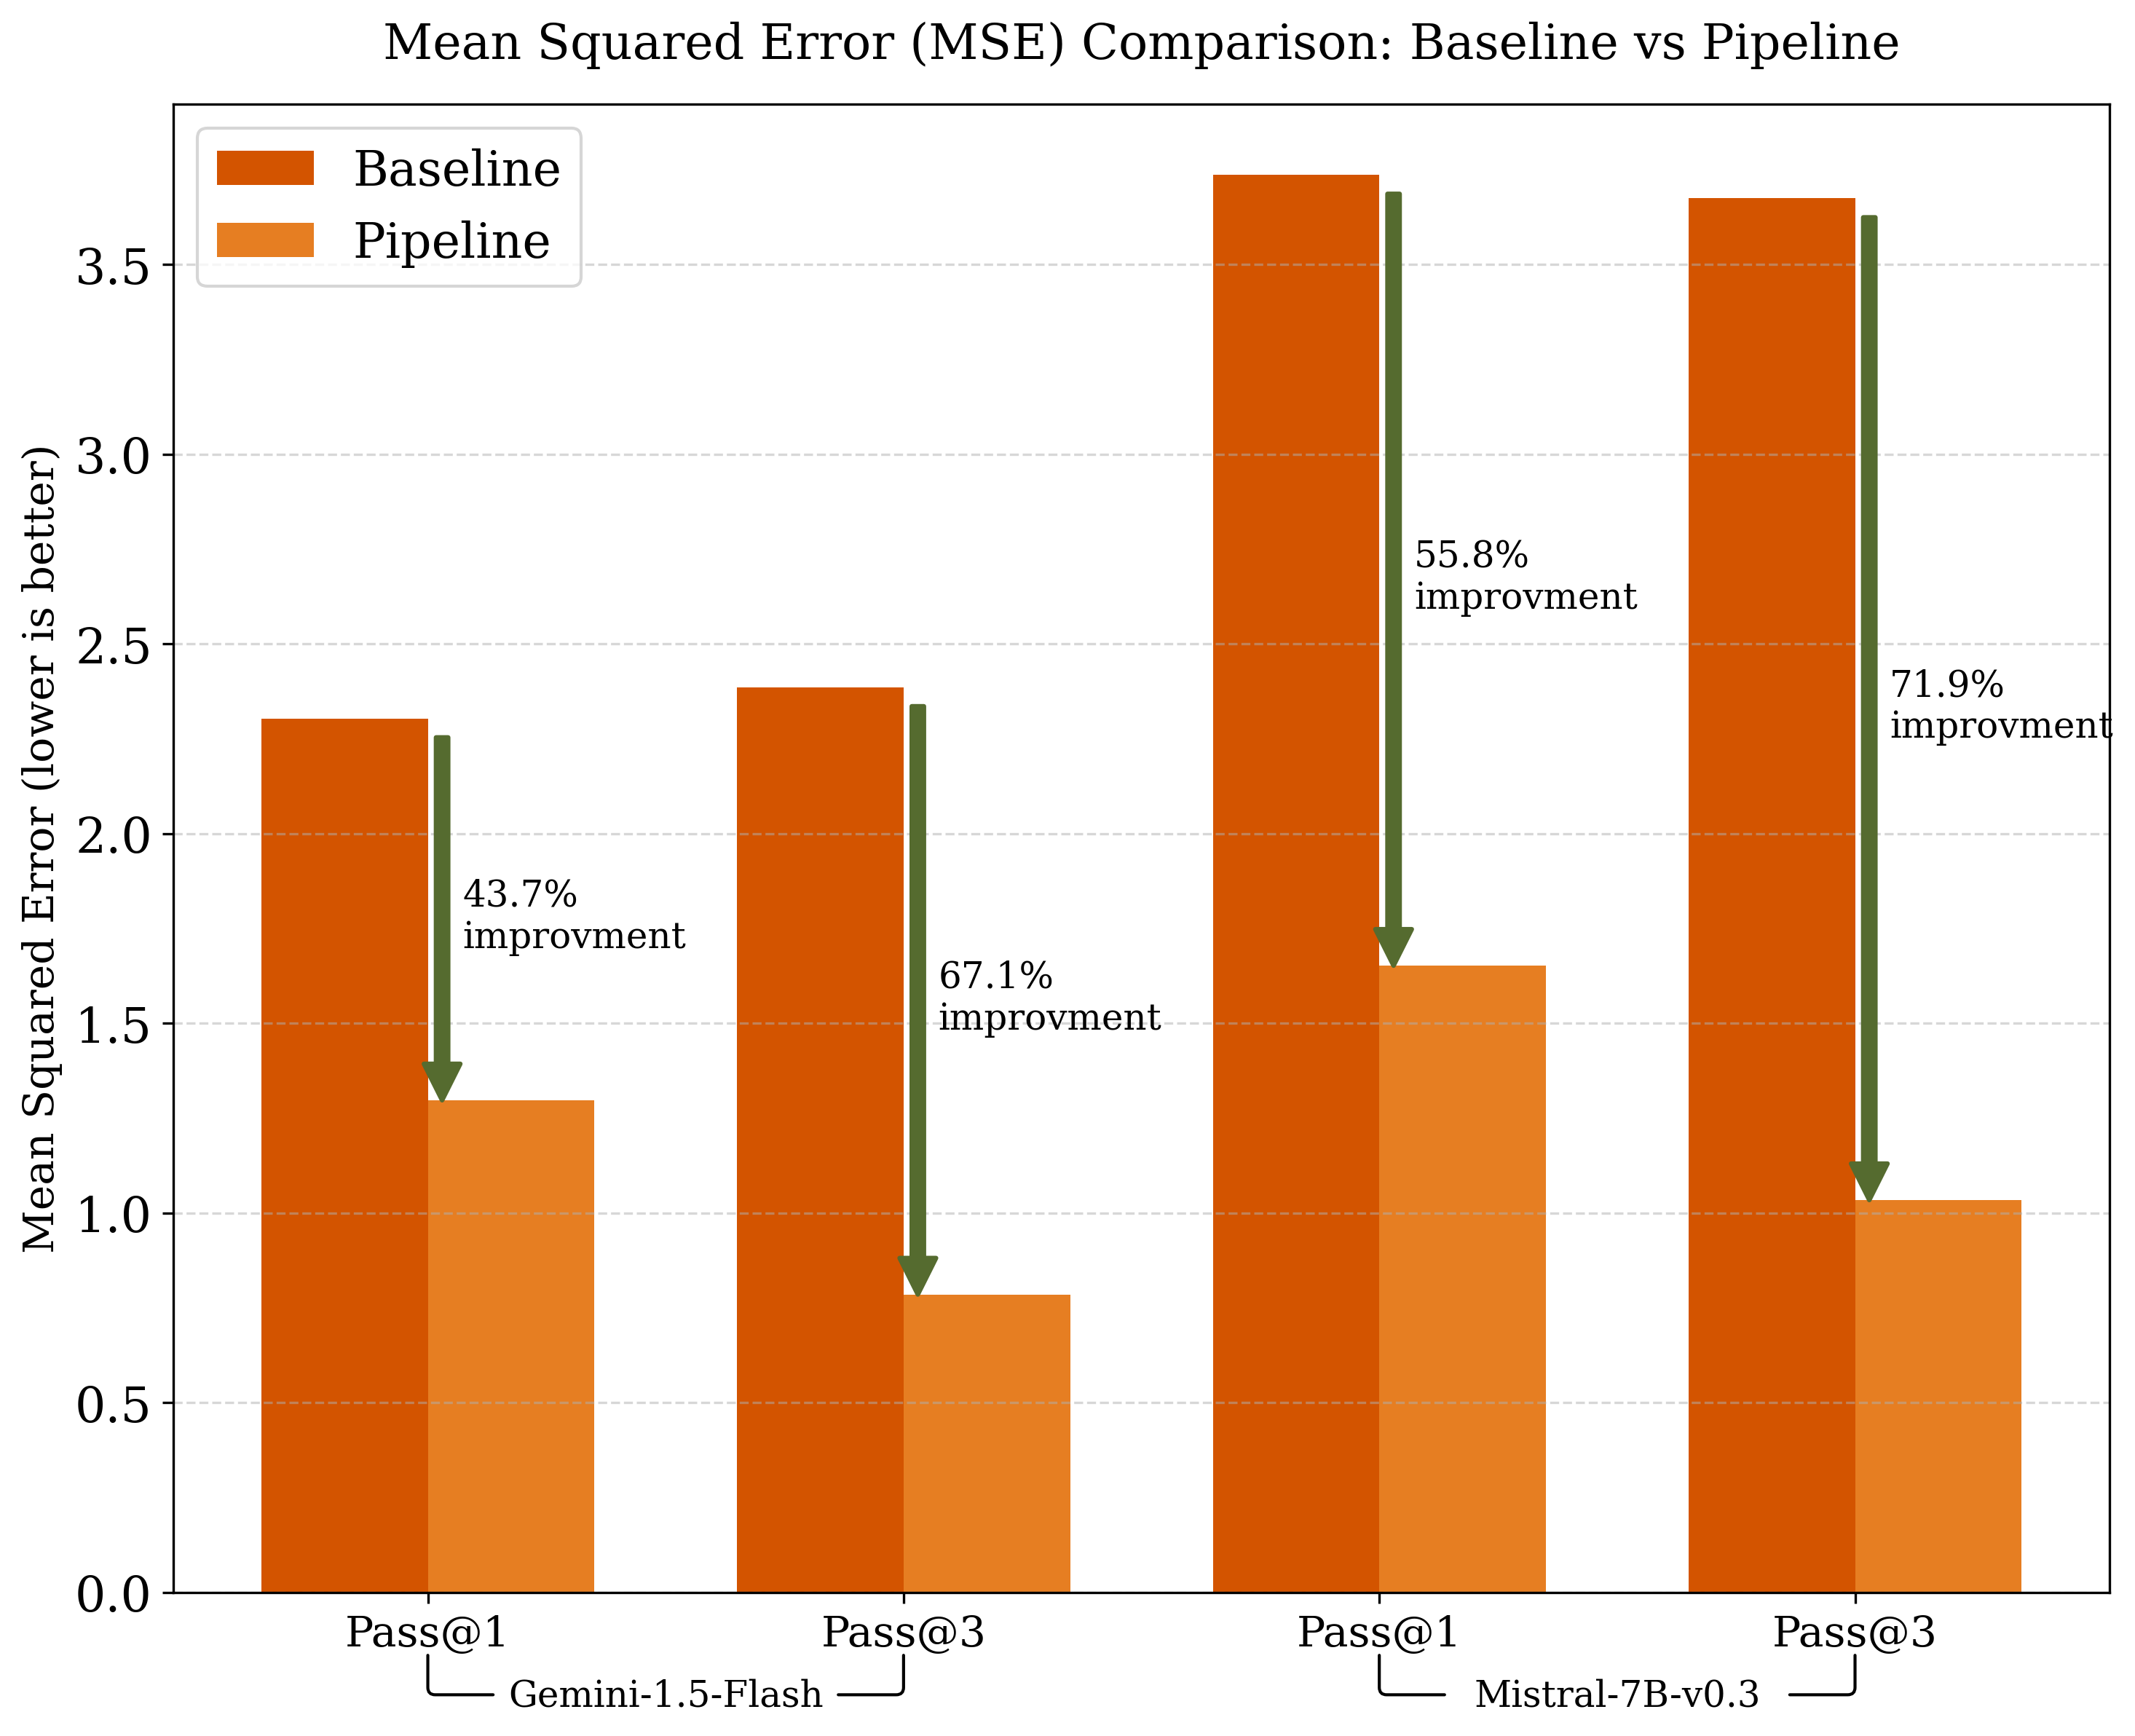

In [146]:
## PLOT: ANALYSIS EXCLUDING UNVERIFIABLE (BASELINE & PIPELINE SEPARATELY)
import numpy as np
import matplotlib.pyplot as plt
from curlyBrace import curlyBrace
import matplotlib.lines as lines

# Calculate ordinal metrics using existing MSE columns
baseline_pass1_values = gemini_df['baseline_pass1_MSE'].dropna().tolist()
pipeline_pass1_values = gemini_df['pipeline_pass1_MSE'].dropna().tolist()
baseline_pass3_values = gemini_df['baseline_pass3_MSE'].dropna().tolist()
pipeline_pass3_values = gemini_df['pipeline_pass3_MSE'].dropna().tolist()

gemini_ordinal_metrics = {
    'baseline_pass@1_mse': np.mean(baseline_pass1_values) if baseline_pass1_values else None,
    'pipeline_pass@1_mse': np.mean(pipeline_pass1_values) if pipeline_pass1_values else None,
    'baseline_pass@3_mse': np.mean(baseline_pass3_values) if baseline_pass3_values else None,
    'pipeline_pass@3_mse': np.mean(pipeline_pass3_values) if pipeline_pass3_values else None
}
print(f"(Baseline: n={len(baseline_pass1_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(baseline_pass1_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass1_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(pipeline_pass1_values)} unverifiable)")
print(f"(Baseline: n={len(baseline_pass3_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(baseline_pass3_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass3_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(pipeline_pass3_values)} unverifiable)")

# Calculate ordinal metrics using existing MSE columns
baseline_pass1_values = mistral_df['baseline_pass1_MSE'].dropna().tolist()
pipeline_pass1_values = mistral_df['pipeline_pass1_MSE'].dropna().tolist()
baseline_pass3_values = mistral_df['baseline_pass3_MSE'].dropna().tolist()
pipeline_pass3_values = mistral_df['pipeline_pass3_MSE'].dropna().tolist()

mistral_ordinal_metrics = {
    'baseline_pass@1_mse': np.mean(baseline_pass1_values) if baseline_pass1_values else None,
    'pipeline_pass@1_mse': np.mean(pipeline_pass1_values) if pipeline_pass1_values else None,
    'baseline_pass@3_mse': np.mean(baseline_pass3_values) if baseline_pass3_values else None,
    'pipeline_pass@3_mse': np.mean(pipeline_pass3_values) if pipeline_pass3_values else None
}

print(f"(Baseline: n={len(baseline_pass1_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(baseline_pass1_values)} unverifiable)",
    f"(Pipeline: n={len(pipeline_pass1_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(pipeline_pass1_values)} unverifiable)")
print(f"(Baseline: n={len(baseline_pass3_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(baseline_pass3_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass3_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(pipeline_pass3_values)} unverifiable)")

# Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
fig, axes = plt.subplots(1, 1, figsize = (10, 8), dpi = 300)

# Define fall colors
colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
bar_width = 0.35
index = np.arange(4)  # Two groups for Pass@1 and Pass@3

# Create bars
baseline_bars = axes.bar(index - bar_width/2, 
                       [gemini_ordinal_metrics['baseline_pass@1_mse'], gemini_ordinal_metrics['baseline_pass@3_mse'], 
                        mistral_ordinal_metrics['baseline_pass@1_mse'], mistral_ordinal_metrics['baseline_pass@3_mse'], ], 
                       bar_width, label='Baseline', color=colors[0])
pipeline_bars = axes.bar(index + bar_width/2, 
                       [gemini_ordinal_metrics['pipeline_pass@1_mse'], gemini_ordinal_metrics['pipeline_pass@3_mse'],
                        mistral_ordinal_metrics['pipeline_pass@1_mse'], mistral_ordinal_metrics['pipeline_pass@3_mse']], 
                       bar_width, label='Pipeline', color=colors[1])

# Customize the plot
axes.set_ylabel('Mean Squared Error (lower is better)', fontsize=14)
axes.yaxis.set_tick_params(labelsize=16)
axes.set_title(f'Mean Squared Error (MSE) Comparison: Baseline vs Pipeline', fontsize=16, pad=15)
axes.set_xticks(index, ["Pass@1", "Pass@3", "Pass@1", "Pass@3"], fontsize=14)
axes.text(0.5, -0.3, 'Gemini-1.5-Flash', fontsize = 12, ha='center')
axes.annotate('', xy=(0.85, -0.27), xytext=(1, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
axes.annotate('', xy=(0.15, -0.27), xytext=(0, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

axes.text(2.5, -0.3, 'Mistral-7B-v0.3', fontsize = 12, ha='center')
axes.annotate('', xy=(2.85, -0.27), xytext=(3, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
axes.annotate('', xy=(2.15, -0.27), xytext=(2, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

axes.legend(fontsize = 16)

# Add improvement arrows and percentages
for idx, (baseline_val, pipeline_val) in enumerate([
    (gemini_ordinal_metrics['baseline_pass@1_mse'], gemini_ordinal_metrics['pipeline_pass@1_mse']),
    (gemini_ordinal_metrics['baseline_pass@3_mse'], gemini_ordinal_metrics['pipeline_pass@3_mse']),
    (mistral_ordinal_metrics['baseline_pass@1_mse'], mistral_ordinal_metrics['pipeline_pass@1_mse']),
    (mistral_ordinal_metrics['baseline_pass@3_mse'], mistral_ordinal_metrics['pipeline_pass@3_mse']),
]): 
    # curlyBrace(fig, axes, [idx+0.05, baseline_val - 0.03], [idx+0.05, pipeline_val + 0.03], 0.03, bool_auto=True, color = 'black', lw=1, int_line_num=1)
    improvement = ((baseline_val - pipeline_val) / baseline_val * 100)
    # Draw arrow
    mid_height = (baseline_val + pipeline_val) / 2
    axes.annotate(
        f'{improvement:.1f}%\nimprovment', 
        xy=(idx + 0.1, mid_height),
        xytext=(idx + 0.073, mid_height - 0.1),
        fontsize=12,
        # color='#2C3E50',  # Dark blue-gray
        # arrowprops=dict(
        #     arrowstyle='->',
        #     color='#2C3E50',
        #     connectionstyle='arc3,rad=-0.2'
        # )
    )
    
    # Draw arrow
    axes.annotate(f'',
                xy=(idx + 0.03, pipeline_val),
                xytext=(idx + 0.03, baseline_val - 0.05),
                ha='center',
                va='bottom',
                color='green',
                fontweight='bold',
                arrowprops=dict(
                              color='darkolivegreen',
                              lw = 1.5,
                              connectionstyle='arc3,rad=0'))
# Add grid for better readability
axes.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('mse.png', dpi = 500, bbox_inches="tight")